In [150]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import optuna

In [151]:
filename = 'data/2018-01-01-2022-01-01.bin'
cols_to_drop = ['subba-name', 'parent', 'parent-name', 'value-units']
dtypes = {'period': 'datetime64',
          'subba': 'category',
          'timezone': 'category',
          'value': 'uint64'}
df = pd.read_pickle(filename).drop(columns=cols_to_drop)
df = df.drop_duplicates().dropna().reset_index(drop=True)
df = df.astype(dtypes)
df = df[df['subba'] == 'ZONJ']
print('df shape:', df.shape)
print(df.head(1))
print(df.tail(1))

df shape: (6356, 4)
        period subba timezone   value
244 2022-01-01  ZONJ  Pacific  111015
           period subba timezone   value
494912 2018-06-26  ZONJ  Arizona  154798


In [152]:
filt = df.value == 0
to_drop = df[filt].index
df = df.drop(index=to_drop).reset_index(drop=True)

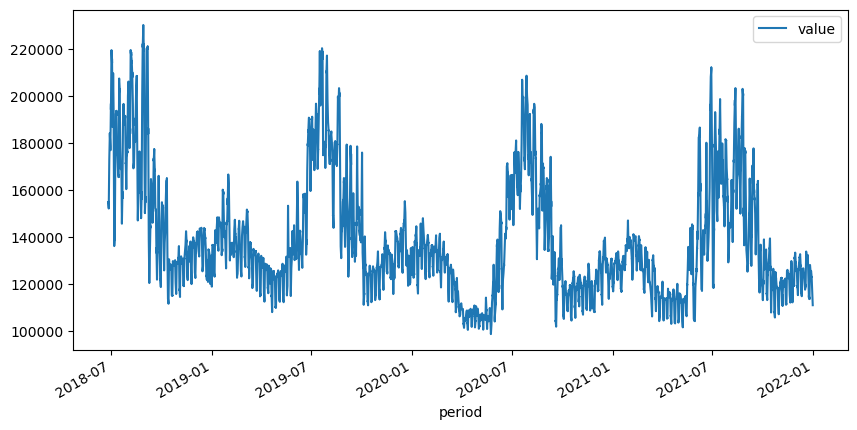

In [153]:
df.sort_values(by='period').plot(x='period', y='value', figsize=(10, 5));

         period subba  timezone   value
0    2022-01-01  ZONJ   Pacific  111015
1    2022-01-01  ZONJ   Arizona  111176
2    2022-01-01  ZONJ   Central  111354
3    2022-01-01  ZONJ  Mountain  111176
4    2022-01-01  ZONJ   Eastern  111503
...         ...   ...       ...     ...
6351 2018-06-26  ZONJ   Pacific  154798
6352 2018-06-26  ZONJ  Mountain  154792
6353 2018-06-26  ZONJ   Eastern  154928
6354 2018-06-26  ZONJ   Central  154836
6355 2018-06-26  ZONJ   Arizona  154798

[6045 rows x 4 columns]


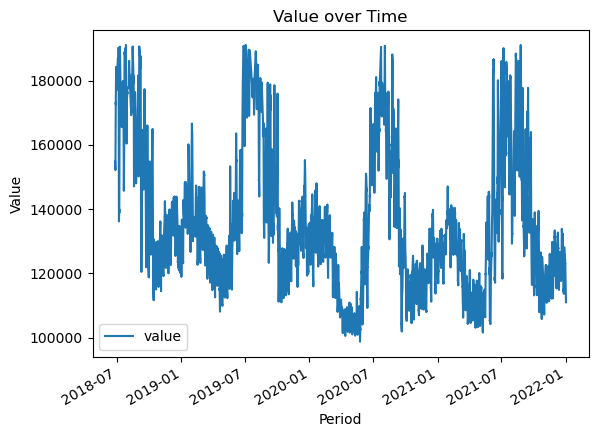

In [154]:
# Compute the IQR for the "value" column
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where the value in the "value" column is outside the bounds
df_filtered = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

print(df_filtered)

# Plotting
df_filtered.plot(x='period', y='value', kind='line')

plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Value over Time')
plt.show()

In [155]:
# Sort df by date in ascending order
df_sorted = df.sort_values(by=['period']).reset_index(drop=True)

In [156]:
def extract_features(df):
    # Separate date features
    df['year'] = df['period'].dt.year.astype('uint16')
    df['month'] = df['period'].dt.month.astype('uint16')
    df['day'] = df['period'].dt.day.astype('uint16')

    # Extract the day of the week
    df['day_of_week'] = df['period'].dt.day_name()

    # Extract quarterly and weekly information to capture seasonality
    df['quarter'] = df['period'].dt.quarter.astype('uint8')
    df['week_of_year'] = df['period'].dt.isocalendar().week.astype('uint16')

    # Mark the weekends
    df['is_weekend'] = (df['period'].dt.weekday >= 5).astype('uint8')
    
    window_size = 7 # 7-day window

    # Create rolling mean feature
    df['rolling_mean_7'] = df['value'].rolling(window=window_size).mean()

    # Create rolling standard deviation feature
    df['rolling_std_7'] = df['value'].rolling(window=window_size).std()
    
    # Remove NaNs introduced by the rolling mean and std
    df = df.dropna().copy().reset_index(drop=True)

    # Create a random feature as a threshold for later feature filtering
    random_feature = [random.random() for _ in range(df.shape[0])]
    df['random_feature'] = random_feature
    return df

df_newfeat = extract_features(df_sorted)

In [157]:
def transform_to_supervised(df):
    print(df.columns.tolist())
    df.loc[:, 'lag'] = df['value'].shift()
    df.dropna(inplace=True)
    df.lag = df.lag.astype('uint64')
    df = df.drop(columns=['period'])
    return df

def encode_categorical(df):
    cols_to_enc = ['timezone', 'day_of_week']

    dummies = pd.get_dummies(df[cols_to_enc])
    df_encoded = pd.concat((dummies, df.drop(columns=cols_to_enc)), axis=1)
    return df_encoded

In [158]:
# Prepare the dataset for feeding it into the model
df_transformed = transform_to_supervised(df_newfeat)
df_transformed
df_encoded = encode_categorical(df_transformed).drop(columns=['subba'])
print(df_encoded.shape)
df_encoded.sample(5)

['period', 'subba', 'timezone', 'value', 'year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year', 'is_weekend', 'rolling_mean_7', 'rolling_std_7', 'random_feature']
(6349, 23)


,timezone_Arizona,timezone_Central,timezone_Eastern,timezone_Mountain,timezone_Pacific,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,...,year,month,day,quarter,week_of_year,is_weekend,rolling_mean_7,rolling_std_7,random_feature,lag
838,0,0,0,0,1,0,0,0,0,0,...,2018,12,11,4,50,0,143033.571429,409.032540,0.885269,142784
4127,0,1,0,0,0,0,0,0,0,0,...,2020,10,7,4,41,0,119082.285714,1101.497876,0.532547,118974
511,0,0,1,0,0,0,0,0,1,0,...,2018,10,7,4,40,1,130615.142857,5879.755534,0.953507,137098
5301,0,0,0,0,1,0,0,0,0,1,...,2021,6,3,2,22,0,123955.142857,2086.054204,0.782688,126404
4744,0,0,0,1,0,0,0,0,0,0,...,2021,2,10,1,6,0,140030.428571,826.003200,0.312548,140119


In [159]:
X = df_encoded.drop(columns=['value'])
y = df_encoded.value

In [160]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

n_splits = 9
tscv = TimeSeriesSplit(n_splits=n_splits)

In [161]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [162]:
def train(model, X, y):
    mae_hist = pd.Series(dtype='float64')
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_hist.loc[mae_hist.size] = mae
        print("Mean Absolute Error for split:", mae)
    avgmae = mae_hist.mean()
    print('Average mae on {} splits: {}'.format(n_splits, avgmae))
    return avgmae
avgmae = train(model, X, y)

Mean Absolute Error for split: 4109.9682940654575
Mean Absolute Error for split: 3027.632147082019
Mean Absolute Error for split: 3823.3160119282334
Mean Absolute Error for split: 2111.7949896490536
Mean Absolute Error for split: 4451.144469637224
Mean Absolute Error for split: 2708.2321199723974
Mean Absolute Error for split: 1564.4033788446372
Mean Absolute Error for split: 3755.4646712342274
Mean Absolute Error for split: 2141.349886632492
Average mae on 9 splits: 3077.033996560638


In [163]:
imp = model.feature_importances_
cols = X.columns.tolist().copy()
feat_imps = pd.DataFrame((cols, imp)).T
feat_imps.columns = ['feature', 'importance']
feat_imps.sort_values(by=['importance'], ascending=False).reset_index(drop=True)

,feature,importance
0,lag,0.898522
1,is_weekend,0.020408
2,day_of_week_Monday,0.018496
3,rolling_mean_7,0.016403
4,day_of_week_Saturday,0.008606
5,day_of_week_Friday,0.007813
6,week_of_year,0.004397
7,rolling_std_7,0.003868
8,day_of_week_Tuesday,0.003358
9,day_of_week_Wednesday,0.002933


In [164]:
threshold = feat_imps[feat_imps['feature'] == 'random_feature']['importance']
not_important = feat_imps[feat_imps['importance'] < threshold.iloc[0]]
to_drop = not_important['feature'].tolist() + ['random_feature']
X_new = X.drop(columns=to_drop)

In [173]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
avgmae = train(model, X_new, y)

Mean Absolute Error for split: 4681.597249605678
Mean Absolute Error for split: 3447.9039456821765
Mean Absolute Error for split: 3970.255052247634
Mean Absolute Error for split: 1946.3447974171925
Mean Absolute Error for split: 4429.073836750788
Mean Absolute Error for split: 3012.620711750789
Mean Absolute Error for split: 1621.859017645899
Mean Absolute Error for split: 4024.3195731466876
Mean Absolute Error for split: 2307.622966778391
Average mae on 9 splits: 3271.2885723361373


In [174]:
cols_to_drop = to_drop + ['value']
cols_to_drop

['timezone_Arizona',
 'timezone_Central',
 'timezone_Eastern',
 'timezone_Mountain',
 'timezone_Pacific',
 'day_of_week_Sunday',
 'quarter',
 'random_feature',
 'value']

In [175]:
test_row = df_encoded.iloc[-1:]
test_row = test_row.drop(columns=cols_to_drop)
test_row

,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,year,month,day,week_of_year,is_weekend,rolling_mean_7,rolling_std_7,lag
6349,0,0,1,0,0,0,2022,1,1,52,1,113067.714286,3116.987419,111176


In [176]:
model.predict(test_row)

array([113215.59], dtype=float32)

In [177]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 150),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBRegressor(**params)
    train(model, X_new, y)
    avgmae = train(model, X, y)
    return avgmae

In [178]:
study = optuna.create_study(direction='minimize')

[I 2023-08-05 18:32:18,766] A new study created in memory with name: no-name-f4a748e7-b977-4bdb-9c76-03e66a2b6e12


In [179]:
# Optimize the study, the objective function is passed in as the first argument
study.optimize(objective, n_trials=100)

Mean Absolute Error for split: 6208.065358832808
Mean Absolute Error for split: 3305.926495958202
Mean Absolute Error for split: 3796.7128721411673
Mean Absolute Error for split: 2226.7292364944797
Mean Absolute Error for split: 5846.355333201893
Mean Absolute Error for split: 3055.4713870268138
Mean Absolute Error for split: 1940.643865832019
Mean Absolute Error for split: 4191.387975650631
Mean Absolute Error for split: 2811.764713130915
Average mae on 9 splits: 3709.2285820298807
Mean Absolute Error for split: 4298.747449231073
Mean Absolute Error for split: 3716.3630717665615
Mean Absolute Error for split: 3699.0452853903785
Mean Absolute Error for split: 2332.103608044164
Mean Absolute Error for split: 5414.448775138013
Mean Absolute Error for split: 3090.757430500789
Mean Absolute Error for split: 1956.1696446175079


[I 2023-08-05 18:32:20,138] Trial 0 finished with value: 3462.523214324834 and parameters: {'n_estimators': 104, 'max_depth': 1, 'learning_rate': 0.26495410226440597, 'subsample': 0.7074456442611345, 'colsample_bytree': 0.8014139086352978, 'min_child_weight': 9}. Best is trial 0 with value: 3462.523214324834.


Mean Absolute Error for split: 3870.6115684148267
Mean Absolute Error for split: 2784.4620958201895
Average mae on 9 splits: 3462.523214324834
Mean Absolute Error for split: 5725.3828125
Mean Absolute Error for split: 3425.070854692429
Mean Absolute Error for split: 4311.419225650631
Mean Absolute Error for split: 2053.428368986593
Mean Absolute Error for split: 4590.103152109621
Mean Absolute Error for split: 3230.6783936317033
Mean Absolute Error for split: 1500.508835272082
Mean Absolute Error for split: 3724.5920248422713
Mean Absolute Error for split: 2172.785402701104
Average mae on 9 splits: 3414.8854522651595
Mean Absolute Error for split: 5100.006777405363
Mean Absolute Error for split: 3566.722175670347
Mean Absolute Error for split: 3829.1630890181386
Mean Absolute Error for split: 2096.9829579061516
Mean Absolute Error for split: 4950.538224566246
Mean Absolute Error for split: 3015.436736001577
Mean Absolute Error for split: 1515.8273979692428
Mean Absolute Error for split

[I 2023-08-05 18:32:22,413] Trial 1 finished with value: 3319.18504096565 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.25375221910323187, 'subsample': 0.9541947717406809, 'colsample_bytree': 0.7757738545821545, 'min_child_weight': 8}. Best is trial 1 with value: 3319.18504096565.


Mean Absolute Error for split: 2097.759956624606
Average mae on 9 splits: 3319.18504096565
Mean Absolute Error for split: 25091.107428036277
Mean Absolute Error for split: 24138.34045987776
Mean Absolute Error for split: 27433.065728509464
Mean Absolute Error for split: 22935.952496549686
Mean Absolute Error for split: 20640.713796332806
Mean Absolute Error for split: 22976.794422811516
Mean Absolute Error for split: 22196.500172515774
Mean Absolute Error for split: 26485.892744479494
Mean Absolute Error for split: 23120.100564373028
Average mae on 9 splits: 23890.940868165086
Mean Absolute Error for split: 24246.161117409305


[I 2023-08-05 18:32:22,758] Trial 2 finished with value: 23799.388294667893 and parameters: {'n_estimators': 9, 'max_depth': 12, 'learning_rate': 0.17357165398339827, 'subsample': 0.6743668850996165, 'colsample_bytree': 0.9881900742602151, 'min_child_weight': 6}. Best is trial 1 with value: 3319.18504096565.


Mean Absolute Error for split: 24138.34045987776
Mean Absolute Error for split: 27370.18413594243
Mean Absolute Error for split: 22935.952496549686
Mean Absolute Error for split: 20684.627563091482
Mean Absolute Error for split: 23134.29643138801
Mean Absolute Error for split: 22187.426951892743
Mean Absolute Error for split: 26376.525643237383
Mean Absolute Error for split: 23120.97985262224
Average mae on 9 splits: 23799.388294667893
Mean Absolute Error for split: 5907.612258477918
Mean Absolute Error for split: 6319.522636533911
Mean Absolute Error for split: 8321.725404179811
Mean Absolute Error for split: 6541.929675177445
Mean Absolute Error for split: 5923.053775630915
Mean Absolute Error for split: 6682.3968971806
Mean Absolute Error for split: 6483.5149102917985
Mean Absolute Error for split: 8613.455121253943
Mean Absolute Error for split: 7110.070756111987
Average mae on 9 splits: 6878.142381648704
Mean Absolute Error for split: 6274.151160784701
Mean Absolute Error for spli

[I 2023-08-05 18:32:24,225] Trial 3 finished with value: 6984.127902646337 and parameters: {'n_estimators': 70, 'max_depth': 12, 'learning_rate': 0.041359330353988324, 'subsample': 0.7476692104672908, 'colsample_bytree': 0.827808689547757, 'min_child_weight': 4}. Best is trial 1 with value: 3319.18504096565.


Mean Absolute Error for split: 7125.059320780757
Average mae on 9 splits: 6984.127902646337
Mean Absolute Error for split: 6247.2214979298105
Mean Absolute Error for split: 4054.1585666403785
Mean Absolute Error for split: 4241.918289136435
Mean Absolute Error for split: 2178.894900926656
Mean Absolute Error for split: 4969.263308359621
Mean Absolute Error for split: 4381.870576202681
Mean Absolute Error for split: 1788.357280165615
Mean Absolute Error for split: 4198.7755076892745
Mean Absolute Error for split: 2256.0759192626183
Average mae on 9 splits: 3812.948427368121
Mean Absolute Error for split: 6689.2849344440065
Mean Absolute Error for split: 3854.851192823344
Mean Absolute Error for split: 4617.548797318612
Mean Absolute Error for split: 2160.0582610410092
Mean Absolute Error for split: 4608.502772574921
Mean Absolute Error for split: 3482.296332807571
Mean Absolute Error for split: 1592.8320682176657
Mean Absolute Error for split: 4312.6686834582015


[I 2023-08-05 18:32:26,045] Trial 4 finished with value: 3735.578234533824 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.15181578090108433, 'subsample': 0.838132642451286, 'colsample_bytree': 0.6131099868900436, 'min_child_weight': 9}. Best is trial 1 with value: 3319.18504096565.


Mean Absolute Error for split: 2302.161068119085
Average mae on 9 splits: 3735.578234533824
Mean Absolute Error for split: 5644.298649447949
Mean Absolute Error for split: 3824.878240832019
Mean Absolute Error for split: 4637.991559049685
Mean Absolute Error for split: 2435.217727227918
Mean Absolute Error for split: 5023.1332684345425
Mean Absolute Error for split: 2679.0942675473184
Mean Absolute Error for split: 1613.4904869873817
Mean Absolute Error for split: 4026.324945780757
Mean Absolute Error for split: 2370.2784158123027
Average mae on 9 splits: 3583.8563956799862
Mean Absolute Error for split: 5048.100515082808
Mean Absolute Error for split: 3213.8542364944797
Mean Absolute Error for split: 3854.274682078076
Mean Absolute Error for split: 2113.2268952089908
Mean Absolute Error for split: 4805.071483142745
Mean Absolute Error for split: 2894.0132467468457
Mean Absolute Error for split: 1509.1438288643533
Mean Absolute Error for split: 3897.7199206427445


[I 2023-08-05 18:32:34,589] Trial 5 finished with value: 3302.9811533364 and parameters: {'n_estimators': 130, 'max_depth': 15, 'learning_rate': 0.2623485449724657, 'subsample': 0.8740575057470152, 'colsample_bytree': 0.8568078480415418, 'min_child_weight': 8}. Best is trial 5 with value: 3302.9811533364.


Mean Absolute Error for split: 2391.4255717665615
Average mae on 9 splits: 3302.9811533364
Mean Absolute Error for split: 4078.8050202089908
Mean Absolute Error for split: 3291.7390329258674
Mean Absolute Error for split: 3703.199021589117
Mean Absolute Error for split: 2093.1952015970032
Mean Absolute Error for split: 4552.647636533911
Mean Absolute Error for split: 2676.7482255520504
Mean Absolute Error for split: 1642.8341753746056
Mean Absolute Error for split: 3749.7915023659307
Mean Absolute Error for split: 2122.8136090299686
Average mae on 9 splits: 3101.3081583530493
Mean Absolute Error for split: 4252.3472003154575
Mean Absolute Error for split: 3147.858241324921
Mean Absolute Error for split: 3766.255520504732
Mean Absolute Error for split: 2113.8232945583595
Mean Absolute Error for split: 4155.291921332808
Mean Absolute Error for split: 2841.6881900630915
Mean Absolute Error for split: 1511.1031028194006
Mean Absolute Error for split: 3613.970512125394


[I 2023-08-05 18:32:38,788] Trial 6 finished with value: 3065.628840529706 and parameters: {'n_estimators': 70, 'max_depth': 14, 'learning_rate': 0.19898637510368164, 'subsample': 0.74930935089311, 'colsample_bytree': 0.9455210339318154, 'min_child_weight': 2}. Best is trial 6 with value: 3065.628840529706.


Mean Absolute Error for split: 2188.3215817231862
Average mae on 9 splits: 3065.628840529706
Mean Absolute Error for split: 5383.0319154179815
Mean Absolute Error for split: 3192.776505816246
Mean Absolute Error for split: 4446.726044952681
Mean Absolute Error for split: 2018.548563190063
Mean Absolute Error for split: 4759.414432176656
Mean Absolute Error for split: 2651.5329751577287
Mean Absolute Error for split: 1564.0117064274448
Mean Absolute Error for split: 3759.839116719243
Mean Absolute Error for split: 2239.333288150631
Average mae on 9 splits: 3335.0238386676306
Mean Absolute Error for split: 4282.1243345820185
Mean Absolute Error for split: 3100.0850502760254
Mean Absolute Error for split: 3584.4703396096215
Mean Absolute Error for split: 2017.550177444795
Mean Absolute Error for split: 4094.6248521293373
Mean Absolute Error for split: 2677.2613244282334
Mean Absolute Error for split: 1473.4520036474764
Mean Absolute Error for split: 3707.779672712934


[I 2023-08-05 18:32:43,287] Trial 7 finished with value: 2999.3761555818437 and parameters: {'n_estimators': 98, 'max_depth': 14, 'learning_rate': 0.1373328308616754, 'subsample': 0.8428784140298313, 'colsample_bytree': 0.848014389963703, 'min_child_weight': 4}. Best is trial 7 with value: 2999.3761555818437.


Mean Absolute Error for split: 2057.0376454061516
Average mae on 9 splits: 2999.3761555818437
Mean Absolute Error for split: 23248.85294262618
Mean Absolute Error for split: 24294.759734818614
Mean Absolute Error for split: 26851.312771096214
Mean Absolute Error for split: 23361.5456920347
Mean Absolute Error for split: 19885.06717024842
Mean Absolute Error for split: 20544.28937056388
Mean Absolute Error for split: 22034.23871253943
Mean Absolute Error for split: 27011.85799487382
Mean Absolute Error for split: 23448.21941541798
Average mae on 9 splits: 23408.904867135472
Mean Absolute Error for split: 24830.710074921135
Mean Absolute Error for split: 23659.133305402207
Mean Absolute Error for split: 26898.22931042981
Mean Absolute Error for split: 23465.142079061516
Mean Absolute Error for split: 20339.84462490142
Mean Absolute Error for split: 22030.418449329653
Mean Absolute Error for split: 22370.08143976735
Mean Absolute Error for split: 26733.619257689275


[I 2023-08-05 18:32:43,501] Trial 8 finished with value: 23770.85431042981 and parameters: {'n_estimators': 5, 'max_depth': 14, 'learning_rate': 0.28833808075059164, 'subsample': 0.8911402013606617, 'colsample_bytree': 0.6704338902062715, 'min_child_weight': 1}. Best is trial 7 with value: 2999.3761555818437.


Mean Absolute Error for split: 23610.51025236593
Average mae on 9 splits: 23770.85431042981
Mean Absolute Error for split: 4223.583423698738
Mean Absolute Error for split: 3343.1292636041007
Mean Absolute Error for split: 4159.227893335962
Mean Absolute Error for split: 2008.6282285094637
Mean Absolute Error for split: 4922.805882787855
Mean Absolute Error for split: 2854.574341975552
Mean Absolute Error for split: 1515.192552247634
Mean Absolute Error for split: 3851.020677247634
Mean Absolute Error for split: 2132.47777011041
Average mae on 9 splits: 3223.4044481685946
Mean Absolute Error for split: 3576.4741842468457
Mean Absolute Error for split: 3241.793732748423
Mean Absolute Error for split: 3896.5017867705046
Mean Absolute Error for split: 1844.7819277405363
Mean Absolute Error for split: 4665.488811119873
Mean Absolute Error for split: 2810.430402208202
Mean Absolute Error for split: 1466.6495342074134


[I 2023-08-05 18:32:45,600] Trial 9 finished with value: 3021.971111823081 and parameters: {'n_estimators': 44, 'max_depth': 15, 'learning_rate': 0.2937896157386961, 'subsample': 0.8533484819464534, 'colsample_bytree': 0.9804165426235213, 'min_child_weight': 7}. Best is trial 7 with value: 2999.3761555818437.


Mean Absolute Error for split: 3518.314360705836
Mean Absolute Error for split: 2177.3052666600947
Average mae on 9 splits: 3021.971111823081
Mean Absolute Error for split: 7067.133169854101
Mean Absolute Error for split: 4812.284885153786
Mean Absolute Error for split: 4626.866694597792
Mean Absolute Error for split: 2604.510572752366
Mean Absolute Error for split: 5184.746980973975
Mean Absolute Error for split: 4089.0865659503156
Mean Absolute Error for split: 1867.0652725749212
Mean Absolute Error for split: 4240.109214806782
Mean Absolute Error for split: 2442.5172762223974
Average mae on 9 splits: 4103.813403654048
Mean Absolute Error for split: 6045.307509365142
Mean Absolute Error for split: 3716.6755101537856
Mean Absolute Error for split: 4134.484128548896
Mean Absolute Error for split: 2434.0120391364353
Mean Absolute Error for split: 4747.697468947161
Mean Absolute Error for split: 3677.717468454259
Mean Absolute Error for split: 1721.761595524448
Mean Absolute Error for sp

[I 2023-08-05 18:32:48,280] Trial 10 finished with value: 3699.0035612184543 and parameters: {'n_estimators': 114, 'max_depth': 9, 'learning_rate': 0.10056503177330539, 'subsample': 0.5531648887521846, 'colsample_bytree': 0.5599398490637643, 'min_child_weight': 4}. Best is trial 7 with value: 2999.3761555818437.


Mean Absolute Error for split: 2591.6421776419556
Average mae on 9 splits: 3699.0035612184543
Mean Absolute Error for split: 4793.547947062303
Mean Absolute Error for split: 2961.2064027996844
Mean Absolute Error for split: 4073.943217665615
Mean Absolute Error for split: 1913.0446939077287
Mean Absolute Error for split: 4816.247991423502
Mean Absolute Error for split: 2462.1241250985804
Mean Absolute Error for split: 1295.9190038446372
Mean Absolute Error for split: 3594.5330860607255
Mean Absolute Error for split: 2103.3452903194006
Average mae on 9 splits: 3112.656862020242
Mean Absolute Error for split: 3803.3269666798105
Mean Absolute Error for split: 3256.665873915615
Mean Absolute Error for split: 3518.2752735607255
Mean Absolute Error for split: 1782.1792808556781
Mean Absolute Error for split: 4434.451732551262
Mean Absolute Error for split: 2679.0306708399053


[I 2023-08-05 18:32:49,442] Trial 11 finished with value: 2936.1419517284435 and parameters: {'n_estimators': 36, 'max_depth': 9, 'learning_rate': 0.2114965589971421, 'subsample': 0.8264345341415285, 'colsample_bytree': 0.9114875892234864, 'min_child_weight': 6}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 1359.8902183556781
Mean Absolute Error for split: 3566.4192379731862
Mean Absolute Error for split: 2025.0383108241324
Average mae on 9 splits: 2936.1419517284435
Mean Absolute Error for split: 3966.5794928036275
Mean Absolute Error for split: 3286.022969242902
Mean Absolute Error for split: 4014.5160193217666
Mean Absolute Error for split: 1852.0734547515772
Mean Absolute Error for split: 4626.788692823344
Mean Absolute Error for split: 2429.5469489353313
Mean Absolute Error for split: 1463.9464831427445
Mean Absolute Error for split: 3779.048304416404
Mean Absolute Error for split: 2137.46122091877
Average mae on 9 splits: 3061.7759540396073
Mean Absolute Error for split: 4023.1241743888013
Mean Absolute Error for split: 2978.578667192429
Mean Absolute Error for split: 3679.3714880717666
Mean Absolute Error for split: 2020.2440605283912
Mean Absolute Error for split: 4527.576658615931
Mean Absolute Error for split: 2676.253376380126
Mean Absolute Error 

[I 2023-08-05 18:32:50,797] Trial 12 finished with value: 2973.7233969724853 and parameters: {'n_estimators': 40, 'max_depth': 9, 'learning_rate': 0.20636072590190332, 'subsample': 0.9516738704834264, 'colsample_bytree': 0.8868950889579541, 'min_child_weight': 4}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 3423.9617261435333
Mean Absolute Error for split: 2007.5458152602523
Average mae on 9 splits: 2973.7233969724853
Mean Absolute Error for split: 4437.044656940063
Mean Absolute Error for split: 3267.7592665615143
Mean Absolute Error for split: 4162.770073442429
Mean Absolute Error for split: 1883.1015994676657
Mean Absolute Error for split: 4564.826744873817
Mean Absolute Error for split: 2438.4014688485804
Mean Absolute Error for split: 1388.8057965299683
Mean Absolute Error for split: 3530.1023511435333
Mean Absolute Error for split: 2102.6025359818614
Average mae on 9 splits: 3086.157165976603
Mean Absolute Error for split: 4511.231799585962
Mean Absolute Error for split: 3121.4300325315457
Mean Absolute Error for split: 3752.0148733241326
Mean Absolute Error for split: 1887.6109276419559
Mean Absolute Error for split: 4748.492606466877
Mean Absolute Error for split: 2449.509426754732
Mean Absolute Error for split: 1307.0430673304415


[I 2023-08-05 18:32:51,928] Trial 13 finished with value: 3019.1454978859974 and parameters: {'n_estimators': 37, 'max_depth': 8, 'learning_rate': 0.2137889699726679, 'subsample': 0.9989503390385495, 'colsample_bytree': 0.9049840420392865, 'min_child_weight': 5}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 3408.4935306585176
Mean Absolute Error for split: 1986.4832166798108
Average mae on 9 splits: 3019.1454978859974
Mean Absolute Error for split: 4258.3882960370665
Mean Absolute Error for split: 3060.09644863959
Mean Absolute Error for split: 4135.870958201893
Mean Absolute Error for split: 1999.8459927050474
Mean Absolute Error for split: 3960.937302839117
Mean Absolute Error for split: 2485.1057891364353
Mean Absolute Error for split: 1454.7146219440062
Mean Absolute Error for split: 3466.044533714511
Mean Absolute Error for split: 2054.324945780757
Average mae on 9 splits: 2986.1476543331582
Mean Absolute Error for split: 4059.5833251182967
Mean Absolute Error for split: 2951.5266043966876
Mean Absolute Error for split: 3781.531114451893
Mean Absolute Error for split: 2050.6991817823346
Mean Absolute Error for split: 4522.287115536277
Mean Absolute Error for split: 2666.135437204259
Mean Absolute Error for split: 1476.2499507097791
Mean Absolute Error f

[I 2023-08-05 18:32:53,321] Trial 14 finished with value: 3029.1946251752543 and parameters: {'n_estimators': 39, 'max_depth': 9, 'learning_rate': 0.2155433404938959, 'subsample': 0.9135557815295721, 'colsample_bytree': 0.9052190822722243, 'min_child_weight': 2}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 2124.8142374802837
Average mae on 9 splits: 3029.1946251752543
Mean Absolute Error for split: 4835.410242507886
Mean Absolute Error for split: 3472.5482304810726
Mean Absolute Error for split: 4212.866608339906
Mean Absolute Error for split: 2099.355900039432
Mean Absolute Error for split: 4687.631173600158
Mean Absolute Error for split: 3911.2311464905365
Mean Absolute Error for split: 1476.7306412657729
Mean Absolute Error for split: 3714.4978189077287
Mean Absolute Error for split: 2081.744762914038
Average mae on 9 splits: 3388.001836060726
Mean Absolute Error for split: 4945.4041551656155
Mean Absolute Error for split: 3434.6359054613563
Mean Absolute Error for split: 4856.685442133281
Mean Absolute Error for split: 2127.1494725946372
Mean Absolute Error for split: 4578.389158615931
Mean Absolute Error for split: 3439.2547811514196
Mean Absolute Error for split: 1542.011287460568
Mean Absolute Error for split: 4374.830293769716


[I 2023-08-05 18:32:54,571] Trial 15 finished with value: 3488.6462564077287 and parameters: {'n_estimators': 54, 'max_depth': 6, 'learning_rate': 0.23595111766132928, 'subsample': 0.9785953289055368, 'colsample_bytree': 0.7637850795049057, 'min_child_weight': 6}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 2099.4558113170347
Average mae on 9 splits: 3488.6462564077287
Mean Absolute Error for split: 4143.885240043375
Mean Absolute Error for split: 3115.9549117705046
Mean Absolute Error for split: 4212.549462736593
Mean Absolute Error for split: 2514.472003154574
Mean Absolute Error for split: 3890.603718947161
Mean Absolute Error for split: 3487.025421431388
Mean Absolute Error for split: 2320.505163150631
Mean Absolute Error for split: 4665.043966876971
Mean Absolute Error for split: 2679.382331920347
Average mae on 9 splits: 3447.713580003505
Mean Absolute Error for split: 4450.025125690063
Mean Absolute Error for split: 2725.517658221609
Mean Absolute Error for split: 4616.521490536277
Mean Absolute Error for split: 2388.465928134858
Mean Absolute Error for split: 4251.449305007886
Mean Absolute Error for split: 3223.481750295741
Mean Absolute Error for split: 2030.171751774448


[I 2023-08-05 18:32:55,279] Trial 16 finished with value: 3461.065525871889 and parameters: {'n_estimators': 22, 'max_depth': 11, 'learning_rate': 0.18185545010197307, 'subsample': 0.8109048765412897, 'colsample_bytree': 0.7042056179573033, 'min_child_weight': 3}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 4714.1488934345425
Mean Absolute Error for split: 2749.807829751577
Average mae on 9 splits: 3461.065525871889
Mean Absolute Error for split: 4543.662115536277
Mean Absolute Error for split: 3166.2119849171922
Mean Absolute Error for split: 4083.211418079653
Mean Absolute Error for split: 2020.9614920149843
Mean Absolute Error for split: 4460.618604593848
Mean Absolute Error for split: 2454.1413766758674
Mean Absolute Error for split: 1371.2717123422713
Mean Absolute Error for split: 3640.439360705836
Mean Absolute Error for split: 2054.901320977918
Average mae on 9 splits: 3088.3799317604276
Mean Absolute Error for split: 4014.2334384858045
Mean Absolute Error for split: 3051.7632097791798
Mean Absolute Error for split: 3792.1339831427445
Mean Absolute Error for split: 1937.6694967468454
Mean Absolute Error for split: 4754.251663544953
Mean Absolute Error for split: 2573.358943710568
Mean Absolute Error for split: 1438.254448442429


[I 2023-08-05 18:32:56,649] Trial 17 finished with value: 3007.0225050933227 and parameters: {'n_estimators': 57, 'max_depth': 6, 'learning_rate': 0.22691668283327354, 'subsample': 0.9230885846697741, 'colsample_bytree': 0.8938196215031493, 'min_child_weight': 5}. Best is trial 11 with value: 2936.1419517284435.


Mean Absolute Error for split: 3433.4486642350157
Mean Absolute Error for split: 2068.088697752366
Average mae on 9 splits: 3007.0225050933227
Mean Absolute Error for split: 3791.2762963328078
Mean Absolute Error for split: 2648.2820386435333
Mean Absolute Error for split: 3542.9144568217666
Mean Absolute Error for split: 1957.1360779771294
Mean Absolute Error for split: 4204.370095623029
Mean Absolute Error for split: 2668.7739550473184
Mean Absolute Error for split: 1808.4526567429023
Mean Absolute Error for split: 3787.4363786474764
Mean Absolute Error for split: 2338.8663865339117
Average mae on 9 splits: 2971.9453713744306
Mean Absolute Error for split: 3433.6490043375393
Mean Absolute Error for split: 2720.0423402996844
Mean Absolute Error for split: 3491.578605579653
Mean Absolute Error for split: 1961.0753277799683
Mean Absolute Error for split: 4205.110792093848


[I 2023-08-05 18:32:57,379] Trial 18 finished with value: 2914.607752530231 and parameters: {'n_estimators': 23, 'max_depth': 8, 'learning_rate': 0.1871153435016287, 'subsample': 0.9475411425491364, 'colsample_bytree': 0.9301393852814467, 'min_child_weight': 10}. Best is trial 18 with value: 2914.607752530231.


Mean Absolute Error for split: 2840.4452262421137
Mean Absolute Error for split: 1735.8062647870663
Mean Absolute Error for split: 3593.698134365142
Mean Absolute Error for split: 2250.064077287066
Average mae on 9 splits: 2914.607752530231
Mean Absolute Error for split: 11164.667426557571
Mean Absolute Error for split: 10537.433371944006
Mean Absolute Error for split: 12761.622436908518
Mean Absolute Error for split: 10262.687894321767
Mean Absolute Error for split: 8339.28094193612
Mean Absolute Error for split: 10536.761620169558
Mean Absolute Error for split: 10016.391019321767
Mean Absolute Error for split: 12543.998989550473
Mean Absolute Error for split: 10644.21415368691
Average mae on 9 splits: 10756.339761599633
Mean Absolute Error for split: 10932.09519173896
Mean Absolute Error for split: 10399.156496451104


[I 2023-08-05 18:32:57,810] Trial 19 finished with value: 10690.904816476077 and parameters: {'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.11773086977062401, 'subsample': 0.8034523640013885, 'colsample_bytree': 0.9489645500301245, 'min_child_weight': 10}. Best is trial 18 with value: 2914.607752530231.


Mean Absolute Error for split: 12752.842912066246
Mean Absolute Error for split: 10187.874063485804
Mean Absolute Error for split: 8037.367101242114
Mean Absolute Error for split: 10593.683162460567
Mean Absolute Error for split: 10021.035119282335
Mean Absolute Error for split: 12618.40177691246
Mean Absolute Error for split: 10675.68752464511
Average mae on 9 splits: 10690.904816476077
Mean Absolute Error for split: 4019.412485212934
Mean Absolute Error for split: 2667.2279795938484
Mean Absolute Error for split: 3633.294595327287
Mean Absolute Error for split: 2051.6124063485804
Mean Absolute Error for split: 4135.083670149842
Mean Absolute Error for split: 2682.12320090694
Mean Absolute Error for split: 1905.2328470031546
Mean Absolute Error for split: 3801.147574921136
Mean Absolute Error for split: 2479.7191443217666
Average mae on 9 splits: 3041.6504337539427
Mean Absolute Error for split: 3668.3923624802837
Mean Absolute Error for split: 2698.640674290221
Mean Absolute Error fo

[I 2023-08-05 18:32:58,438] Trial 20 finished with value: 3027.7408196963725 and parameters: {'n_estimators': 23, 'max_depth': 7, 'learning_rate': 0.17841872931222166, 'subsample': 0.9022068972147146, 'colsample_bytree': 0.9973770286365943, 'min_child_weight': 7}. Best is trial 18 with value: 2914.607752530231.


Mean Absolute Error for split: 2841.6400581624607
Mean Absolute Error for split: 1910.101747338328
Mean Absolute Error for split: 3708.639897969243
Mean Absolute Error for split: 2529.481602425079
Average mae on 9 splits: 3027.7408196963725
Mean Absolute Error for split: 4544.553960469243
Mean Absolute Error for split: 3090.7128844637223
Mean Absolute Error for split: 3940.9327681388013
Mean Absolute Error for split: 1952.8573417783912
Mean Absolute Error for split: 4590.50059148265
Mean Absolute Error for split: 2601.234572160883
Mean Absolute Error for split: 1405.6012174684543
Mean Absolute Error for split: 3635.5504362184543
Mean Absolute Error for split: 2056.313744578076
Average mae on 9 splits: 3090.9175018620745
Mean Absolute Error for split: 3732.900680205047
Mean Absolute Error for split: 2994.175719637224
Mean Absolute Error for split: 3594.116411179022
Mean Absolute Error for split: 1865.8736938091483
Mean Absolute Error for split: 4531.123656841482
Mean Absolute Error for 

[I 2023-08-05 18:32:59,612] Trial 21 finished with value: 2912.9965606379246 and parameters: {'n_estimators': 32, 'max_depth': 10, 'learning_rate': 0.20535450951532871, 'subsample': 0.9536031699948764, 'colsample_bytree': 0.8748182495856733, 'min_child_weight': 10}. Best is trial 21 with value: 2912.9965606379246.


Mean Absolute Error for split: 3478.174869380915
Mean Absolute Error for split: 2051.954320287855
Average mae on 9 splits: 2912.9965606379246
Mean Absolute Error for split: 4051.030473679022
Mean Absolute Error for split: 2899.726081920347
Mean Absolute Error for split: 3770.2666724171922
Mean Absolute Error for split: 1842.8201646293376
Mean Absolute Error for split: 4848.831624605678
Mean Absolute Error for split: 2523.0527898264986
Mean Absolute Error for split: 1349.579320287855
Mean Absolute Error for split: 3824.4903021490536
Mean Absolute Error for split: 2060.425830540221
Average mae on 9 splits: 3018.91369556169
Mean Absolute Error for split: 4038.1556215496844
Mean Absolute Error for split: 2857.0423895899053
Mean Absolute Error for split: 3672.938337933754
Mean Absolute Error for split: 1979.1003548895899
Mean Absolute Error for split: 4426.539580047319
Mean Absolute Error for split: 2614.5048304416405
Mean Absolute Error for split: 1314.359498225552
Mean Absolute Error for 

[I 2023-08-05 18:33:00,635] Trial 22 finished with value: 2935.284481247809 and parameters: {'n_estimators': 27, 'max_depth': 11, 'learning_rate': 0.23743877917110262, 'subsample': 0.9953668556676918, 'colsample_bytree': 0.9422508045880912, 'min_child_weight': 10}. Best is trial 21 with value: 2912.9965606379246.


Mean Absolute Error for split: 1998.9379682570977
Average mae on 9 splits: 2935.284481247809
Mean Absolute Error for split: 3815.4541847397477
Mean Absolute Error for split: 3149.0738613958993
Mean Absolute Error for split: 4090.6460099566248
Mean Absolute Error for split: 2648.8909577089908
Mean Absolute Error for split: 4215.697271786277
Mean Absolute Error for split: 3017.312487677445
Mean Absolute Error for split: 2514.2733389195582
Mean Absolute Error for split: 4457.435811809937
Mean Absolute Error for split: 2961.2596978509464
Average mae on 9 splits: 3430.004846871714
Mean Absolute Error for split: 3376.391352030757
Mean Absolute Error for split: 3069.8062278194006
Mean Absolute Error for split: 4254.114414925079
Mean Absolute Error for split: 2606.335173501577
Mean Absolute Error for split: 4162.09793966877
Mean Absolute Error for split: 3479.295544164038


[I 2023-08-05 18:33:01,183] Trial 23 finished with value: 3447.1668117989834 and parameters: {'n_estimators': 15, 'max_depth': 11, 'learning_rate': 0.23953489660625632, 'subsample': 0.9868991411276472, 'colsample_bytree': 0.9490529573767141, 'min_child_weight': 10}. Best is trial 21 with value: 2912.9965606379246.


Mean Absolute Error for split: 2540.1312598580444
Mean Absolute Error for split: 4466.171739451893
Mean Absolute Error for split: 3070.1576547712934
Average mae on 9 splits: 3447.1668117989834
Mean Absolute Error for split: 5468.272217567035
Mean Absolute Error for split: 3537.377513801262
Mean Absolute Error for split: 4301.669274940852
Mean Absolute Error for split: 1899.087748915615
Mean Absolute Error for split: 4957.048760350946
Mean Absolute Error for split: 2514.000653095426
Mean Absolute Error for split: 1420.796936612776
Mean Absolute Error for split: 3789.8411992310726
Mean Absolute Error for split: 2311.3794977326497
Average mae on 9 splits: 3355.4970891386265
Mean Absolute Error for split: 4390.836923304417
Mean Absolute Error for split: 3304.8555673304418
Mean Absolute Error for split: 3746.824095524448
Mean Absolute Error for split: 2096.1482896293373
Mean Absolute Error for split: 4550.388505520505
Mean Absolute Error for split: 3130.4819474566248
Mean Absolute Error for

[I 2023-08-05 18:33:03,096] Trial 24 finished with value: 3140.922025609008 and parameters: {'n_estimators': 57, 'max_depth': 11, 'learning_rate': 0.19031610106607655, 'subsample': 0.9378094159520878, 'colsample_bytree': 0.812810759901296, 'min_child_weight': 10}. Best is trial 21 with value: 2912.9965606379246.
[I 2023-08-05 18:33:03,270] Trial 25 finished with value: 94729.83695137248 and parameters: {'n_estimators': 2, 'max_depth': 10, 'learning_rate': 0.16299552206848233, 'subsample': 0.9934797223527578, 'colsample_bytree': 0.854284740803152, 'min_child_weight': 9}. Best is trial 21 with value: 2912.9965606379246.


Mean Absolute Error for split: 2205.5369799881705
Average mae on 9 splits: 3140.922025609008
Mean Absolute Error for split: 95395.97262544361
Mean Absolute Error for split: 96296.36266512224
Mean Absolute Error for split: 106422.95503499606
Mean Absolute Error for split: 91070.29055352918
Mean Absolute Error for split: 91531.09374383872
Mean Absolute Error for split: 91784.42682250592
Mean Absolute Error for split: 87162.46086972594
Mean Absolute Error for split: 102276.1481910489
Mean Absolute Error for split: 90716.92002661672
Average mae on 9 splits: 94739.62561475858
Mean Absolute Error for split: 95128.286998472
Mean Absolute Error for split: 96296.36266512224
Mean Absolute Error for split: 106422.95503499606
Mean Absolute Error for split: 91070.29055352918
Mean Absolute Error for split: 91531.09374383872
Mean Absolute Error for split: 91964.01447900236
Mean Absolute Error for split: 87162.46086972594
Mean Absolute Error for split: 102276.1481910489
Mean Absolute Error for split: 

[I 2023-08-05 18:33:04,265] Trial 26 finished with value: 2941.7539870311953 and parameters: {'n_estimators': 26, 'max_depth': 12, 'learning_rate': 0.24091062374386646, 'subsample': 0.9583023444854918, 'colsample_bytree': 0.9475737779820558, 'min_child_weight': 8}. Best is trial 21 with value: 2912.9965606379246.


Mean Absolute Error for split: 2061.5034996056784
Average mae on 9 splits: 2941.7539870311953
Mean Absolute Error for split: 4360.152972200315
Mean Absolute Error for split: 2774.9746771490536
Mean Absolute Error for split: 3625.8818266955836
Mean Absolute Error for split: 1888.1006999211356
Mean Absolute Error for split: 4574.492323048107
Mean Absolute Error for split: 2432.6993050078863
Mean Absolute Error for split: 1348.6446051853313
Mean Absolute Error for split: 3494.983845130126
Mean Absolute Error for split: 2125.8333251182967
Average mae on 9 splits: 2958.418175495093
Mean Absolute Error for split: 3875.91948442429
Mean Absolute Error for split: 3169.529672712934
Mean Absolute Error for split: 3520.510277011041
Mean Absolute Error for split: 1888.767966285489
Mean Absolute Error for split: 4420.187142645899
Mean Absolute Error for split: 2551.0074058556784


[I 2023-08-05 18:33:05,074] Trial 27 finished with value: 2912.149331569839 and parameters: {'n_estimators': 30, 'max_depth': 7, 'learning_rate': 0.19969266458905877, 'subsample': 0.9233670520745075, 'colsample_bytree': 0.8710347949125086, 'min_child_weight': 10}. Best is trial 27 with value: 2912.149331569839.


Mean Absolute Error for split: 1348.3503302444794
Mean Absolute Error for split: 3418.3856713328078
Mean Absolute Error for split: 2016.6860336159307
Average mae on 9 splits: 2912.149331569839
Mean Absolute Error for split: 4716.665824625395
Mean Absolute Error for split: 3214.022291502366
Mean Absolute Error for split: 3940.51624112776
Mean Absolute Error for split: 1878.4027996845425
Mean Absolute Error for split: 4409.094329160094
Mean Absolute Error for split: 2642.8812105678235
Mean Absolute Error for split: 1328.7916995268138
Mean Absolute Error for split: 3801.607280165615
Mean Absolute Error for split: 1998.2675226735016
Average mae on 9 splits: 3103.3610221148792
Mean Absolute Error for split: 4555.006383083596
Mean Absolute Error for split: 3269.5738244282334
Mean Absolute Error for split: 3634.6936736001576
Mean Absolute Error for split: 1877.175066541798
Mean Absolute Error for split: 4528.280214905363
Mean Absolute Error for split: 2570.5378302444797
Mean Absolute Error fo

[I 2023-08-05 18:33:07,467] Trial 28 finished with value: 3018.5121349785313 and parameters: {'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.18983831329801362, 'subsample': 0.9203511988788408, 'colsample_bytree': 0.8733490323644195, 'min_child_weight': 9}. Best is trial 27 with value: 2912.149331569839.


Mean Absolute Error for split: 3457.8049462736594
Mean Absolute Error for split: 1950.240745761041
Average mae on 9 splits: 3018.5121349785313
Mean Absolute Error for split: 5728.302025828076
Mean Absolute Error for split: 3303.9689225157726
Mean Absolute Error for split: 4289.748077681388
Mean Absolute Error for split: 2100.2193907728706
Mean Absolute Error for split: 4694.795729002366
Mean Absolute Error for split: 2603.1342295938484
Mean Absolute Error for split: 1549.4403711553628
Mean Absolute Error for split: 3746.7324280362777
Mean Absolute Error for split: 2197.201744873817
Average mae on 9 splits: 3357.0603243844203
Mean Absolute Error for split: 4245.882418178234
Mean Absolute Error for split: 3214.5166108044164
Mean Absolute Error for split: 3763.942798698738
Mean Absolute Error for split: 1944.7081526025236
Mean Absolute Error for split: 5020.200771391956
Mean Absolute Error for split: 3227.860040417981


[I 2023-08-05 18:33:08,363] Trial 29 finished with value: 3162.274393182615 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.27158609449781057, 'subsample': 0.8856649626069822, 'colsample_bytree': 0.7958922483606297, 'min_child_weight': 9}. Best is trial 27 with value: 2912.149331569839.


Mean Absolute Error for split: 1432.1766561514196
Mean Absolute Error for split: 3459.0454086159307
Mean Absolute Error for split: 2152.1366817823346
Average mae on 9 splits: 3162.274393182615
Mean Absolute Error for split: 4500.94711159306
Mean Absolute Error for split: 3086.962021884858
Mean Absolute Error for split: 3499.7943119085176
Mean Absolute Error for split: 1984.869898462145
Mean Absolute Error for split: 5352.992360015773
Mean Absolute Error for split: 2440.7273881111987
Mean Absolute Error for split: 1517.4228484818611
Mean Absolute Error for split: 3392.4778686908517
Mean Absolute Error for split: 2389.765871451104
Average mae on 9 splits: 3129.5510756221524
Mean Absolute Error for split: 4297.109880224763
Mean Absolute Error for split: 3060.691825216877
Mean Absolute Error for split: 3344.3781668966876
Mean Absolute Error for split: 2110.004620958202
Mean Absolute Error for split: 4922.8044903391165
Mean Absolute Error for split: 2633.3699107847
Mean Absolute Error for s

[I 2023-08-05 18:33:09,134] Trial 30 finished with value: 3061.0574819816857 and parameters: {'n_estimators': 66, 'max_depth': 2, 'learning_rate': 0.15901897350305713, 'subsample': 0.9451216168438313, 'colsample_bytree': 0.8072970860725236, 'min_child_weight': 8}. Best is trial 27 with value: 2912.149331569839.


Mean Absolute Error for split: 2314.385141462934
Average mae on 9 splits: 3061.0574819816857
Mean Absolute Error for split: 4056.466273166404
Mean Absolute Error for split: 3156.674783123028
Mean Absolute Error for split: 3693.892867705047
Mean Absolute Error for split: 1883.7938929416405
Mean Absolute Error for split: 4797.53248225552
Mean Absolute Error for split: 2650.4223802247634
Mean Absolute Error for split: 1335.2359769321768
Mean Absolute Error for split: 3760.4996796135647
Mean Absolute Error for split: 2070.2016709384857
Average mae on 9 splits: 3044.9688896556254
Mean Absolute Error for split: 3976.9301434345425
Mean Absolute Error for split: 3165.361950414038
Mean Absolute Error for split: 3896.9608389195582
Mean Absolute Error for split: 1795.4039333596215
Mean Absolute Error for split: 4222.510030559937
Mean Absolute Error for split: 2452.3060553036275
Mean Absolute Error for split: 1349.7390452484228


[I 2023-08-05 18:33:10,220] Trial 31 finished with value: 2936.338532082457 and parameters: {'n_estimators': 35, 'max_depth': 8, 'learning_rate': 0.22510765665572796, 'subsample': 0.9725880653380425, 'colsample_bytree': 0.9290154346871721, 'min_child_weight': 10}. Best is trial 27 with value: 2912.149331569839.


Mean Absolute Error for split: 3574.1470696963725
Mean Absolute Error for split: 1993.6877218059938
Average mae on 9 splits: 2936.338532082457
Mean Absolute Error for split: 4422.68719193612
Mean Absolute Error for split: 2989.610656545741
Mean Absolute Error for split: 3809.7145849763406
Mean Absolute Error for split: 1967.599467665615
Mean Absolute Error for split: 4899.084002858833
Mean Absolute Error for split: 2612.076498422713
Mean Absolute Error for split: 1432.636595524448
Mean Absolute Error for split: 3820.482810035489
Mean Absolute Error for split: 1993.9747880520504
Average mae on 9 splits: 3105.3185106685946
Mean Absolute Error for split: 3742.563350256309
Mean Absolute Error for split: 2884.027282137224
Mean Absolute Error for split: 3613.252045544164
Mean Absolute Error for split: 1901.3952089905363
Mean Absolute Error for split: 4548.535883280757
Mean Absolute Error for split: 2487.317404376972
Mean Absolute Error for split: 1337.5862702089905
Mean Absolute Error for sp

[I 2023-08-05 18:33:11,269] Trial 32 finished with value: 2907.1863170347006 and parameters: {'n_estimators': 31, 'max_depth': 10, 'learning_rate': 0.25218586612415816, 'subsample': 0.9374241689107186, 'colsample_bytree': 0.8774868065804317, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2091.0584951695582
Average mae on 9 splits: 2907.1863170347006
Mean Absolute Error for split: 4444.960074921136
Mean Absolute Error for split: 3988.2563584384857
Mean Absolute Error for split: 5305.624088130915
Mean Absolute Error for split: 3883.924869380915
Mean Absolute Error for split: 4274.709286277603
Mean Absolute Error for split: 4260.321298304417
Mean Absolute Error for split: 3770.3590176458993


[I 2023-08-05 18:33:11,694] Trial 33 finished with value: 4561.980823365756 and parameters: {'n_estimators': 12, 'max_depth': 7, 'learning_rate': 0.25472413840772046, 'subsample': 0.9366729112138301, 'colsample_bytree': 0.8418050135462736, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 5813.636250492902
Mean Absolute Error for split: 4509.819375985804
Average mae on 9 splits: 4472.401179953119
Mean Absolute Error for split: 4029.042734621451
Mean Absolute Error for split: 4006.1736987381705
Mean Absolute Error for split: 5639.214671234227
Mean Absolute Error for split: 3886.703667192429
Mean Absolute Error for split: 4850.0718528194
Mean Absolute Error for split: 4543.506111987382
Mean Absolute Error for split: 3758.741090792587
Mean Absolute Error for split: 5885.255212440852
Mean Absolute Error for split: 4459.118370465299
Average mae on 9 splits: 4561.980823365756
Mean Absolute Error for split: 4134.091753746056
Mean Absolute Error for split: 2997.0157851932177
Mean Absolute Error for split: 3748.805537756309
Mean Absolute Error for split: 2012.3074600749212
Mean Absolute Error for split: 4667.589880717665
Mean Absolute Error for split: 2632.0390994676654
Mean Absolute Error for split: 1401.138456230284
Mean Absolute Error for split:

[I 2023-08-05 18:33:12,701] Trial 34 finished with value: 2956.487696613214 and parameters: {'n_estimators': 31, 'max_depth': 10, 'learning_rate': 0.2051901818571904, 'subsample': 0.873885038300725, 'colsample_bytree': 0.8759255375612617, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3480.52222988959
Mean Absolute Error for split: 2022.234732354101
Average mae on 9 splits: 2956.487696613214
Mean Absolute Error for split: 4595.311649743691
Mean Absolute Error for split: 3005.294065457413
Mean Absolute Error for split: 4102.385967074132
Mean Absolute Error for split: 2111.754620958202
Mean Absolute Error for split: 4445.764010745268
Mean Absolute Error for split: 3368.027097298896
Mean Absolute Error for split: 1828.38340398265
Mean Absolute Error for split: 3855.438941738959
Mean Absolute Error for split: 2444.34827237776
Average mae on 9 splits: 3306.3008921529968
Mean Absolute Error for split: 3006.6158813091483
Mean Absolute Error for split: 2847.4243641561516
Mean Absolute Error for split: 3581.901616719243
Mean Absolute Error for split: 2129.989957117508
Mean Absolute Error for split: 4603.740178923502
Mean Absolute Error for split: 2647.5092295938484


[I 2023-08-05 18:33:13,109] Trial 35 finished with value: 2978.3982827834734 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.27136376837812504, 'subsample': 0.9627046221327097, 'colsample_bytree': 0.7854029689196204, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 1852.6616472791798
Mean Absolute Error for split: 3764.802407827287
Mean Absolute Error for split: 2370.939262125394
Average mae on 9 splits: 2978.3982827834734
Mean Absolute Error for split: 5340.675152799685
Mean Absolute Error for split: 3207.7350527405365
Mean Absolute Error for split: 4121.917574428234
Mean Absolute Error for split: 1919.1438535094637
Mean Absolute Error for split: 4839.725823146688
Mean Absolute Error for split: 2662.9532112578863
Mean Absolute Error for split: 1377.1567798698738
Mean Absolute Error for split: 3641.3304293178235
Mean Absolute Error for split: 2120.012852425079
Average mae on 9 splits: 3247.85008105503
Mean Absolute Error for split: 4510.5163397082015
Mean Absolute Error for split: 3205.417586750789
Mean Absolute Error for split: 3801.9085050276026
Mean Absolute Error for split: 1969.5825980875395
Mean Absolute Error for split: 4556.78754682571
Mean Absolute Error for split: 2632.817539925079
Mean Absolute Error for 

[I 2023-08-05 18:33:14,525] Trial 36 finished with value: 3067.766298633018 and parameters: {'n_estimators': 46, 'max_depth': 8, 'learning_rate': 0.19430749963095859, 'subsample': 0.9112504676562608, 'colsample_bytree': 0.8238352301135293, 'min_child_weight': 8}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2047.0518902799683
Average mae on 9 splits: 3067.766298633018
Mean Absolute Error for split: 4524.15231910489
Mean Absolute Error for split: 3469.3196224369085
Mean Absolute Error for split: 3956.774102917981
Mean Absolute Error for split: 2119.9010375591483
Mean Absolute Error for split: 4984.960518533123
Mean Absolute Error for split: 2612.406447160883
Mean Absolute Error for split: 1484.6131949921137
Mean Absolute Error for split: 3719.0249901419556
Mean Absolute Error for split: 2008.5028095425866
Average mae on 9 splits: 3208.85056026551
Mean Absolute Error for split: 4616.434789037855
Mean Absolute Error for split: 3432.1268237381705
Mean Absolute Error for split: 3825.080121253943
Mean Absolute Error for split: 1861.8033813091483
Mean Absolute Error for split: 4361.344797417192
Mean Absolute Error for split: 2663.004916699527
Mean Absolute Error for split: 1475.0632516758676
Mean Absolute Error for split: 3712.206267251577


[I 2023-08-05 18:33:19,373] Trial 37 finished with value: 3118.0252872524534 and parameters: {'n_estimators': 143, 'max_depth': 10, 'learning_rate': 0.17110278377846225, 'subsample': 0.8666161849696083, 'colsample_bytree': 0.8677691256447297, 'min_child_weight': 7}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2115.1632368888013
Average mae on 9 splits: 3118.0252872524534
Mean Absolute Error for split: 5628.640329258675
Mean Absolute Error for split: 3585.184025039432
Mean Absolute Error for split: 4818.537312697161
Mean Absolute Error for split: 1981.3712416206624
Mean Absolute Error for split: 4826.801557570978
Mean Absolute Error for split: 3798.0520135055203
Mean Absolute Error for split: 1431.6081673895899
Mean Absolute Error for split: 3991.1306314077287
Mean Absolute Error for split: 2359.7260572752366
Average mae on 9 splits: 3602.33903730722
Mean Absolute Error for split: 5266.239538150631
Mean Absolute Error for split: 3349.565568316246
Mean Absolute Error for split: 5016.766931190852
Mean Absolute Error for split: 2231.1530954258674
Mean Absolute Error for split: 4814.570435725552
Mean Absolute Error for split: 3500.7096436317033
Mean Absolute Error for split: 1404.1898782531546
Mean Absolute Error for split: 4464.881050374605


[I 2023-08-05 18:33:21,887] Trial 38 finished with value: 3589.892005126183 and parameters: {'n_estimators': 62, 'max_depth': 13, 'learning_rate': 0.22197939788465024, 'subsample': 0.8981597070595282, 'colsample_bytree': 0.7464697875287505, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2260.9519050670347
Average mae on 9 splits: 3589.892005126183
Mean Absolute Error for split: 6195.843244775237
Mean Absolute Error for split: 3928.16917636041
Mean Absolute Error for split: 4447.407383675079
Mean Absolute Error for split: 2090.2963204850157
Mean Absolute Error for split: 4643.9627735607255
Mean Absolute Error for split: 2624.3486420544164
Mean Absolute Error for split: 1388.2653415812304
Mean Absolute Error for split: 3717.829702287066
Mean Absolute Error for split: 2126.570176951893
Average mae on 9 splits: 3462.5214179701193
Mean Absolute Error for split: 4592.289469144322
Mean Absolute Error for split: 3535.8231466876973
Mean Absolute Error for split: 3810.888049585962
Mean Absolute Error for split: 2039.9998398067823
Mean Absolute Error for split: 4574.799450414038
Mean Absolute Error for split: 2667.4622313682967
Mean Absolute Error for split: 1485.7664013209778
Mean Absolute Error for split: 3691.148671628549


[I 2023-08-05 18:33:23,417] Trial 39 finished with value: 3160.797232354101 and parameters: {'n_estimators': 76, 'max_depth': 5, 'learning_rate': 0.2553790011229116, 'subsample': 0.9602854501532521, 'colsample_bytree': 0.8329801624338178, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2048.9978312302837
Average mae on 9 splits: 3160.797232354101
Mean Absolute Error for split: 25223.228090496847
Mean Absolute Error for split: 24394.50584089117
Mean Absolute Error for split: 30823.57436662066
Mean Absolute Error for split: 24419.833041699527
Mean Absolute Error for split: 18811.340841876972
Mean Absolute Error for split: 23863.488059444007
Mean Absolute Error for split: 23719.853139787065
Mean Absolute Error for split: 29009.940827089904
Mean Absolute Error for split: 25480.79872338328
Average mae on 9 splits: 25082.951436809937
Mean Absolute Error for split: 25311.86941788249
Mean Absolute Error for split: 24394.50584089117
Mean Absolute Error for split: 30905.143052543375
Mean Absolute Error for split: 24419.833041699527
Mean Absolute Error for split: 18640.66881900631
Mean Absolute Error for split: 23927.20450512618
Mean Absolute Error for split: 23719.853139787065
Mean Absolute Error for split: 29506.21186169164


[I 2023-08-05 18:33:23,624] Trial 40 finished with value: 25145.120933556784 and parameters: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.14673299734840445, 'subsample': 0.8532041754683547, 'colsample_bytree': 0.9712861099884155, 'min_child_weight': 8}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 25480.79872338328
Average mae on 9 splits: 25145.120933556784
Mean Absolute Error for split: 4238.702940161672
Mean Absolute Error for split: 3412.0681806979496
Mean Absolute Error for split: 3754.7244306979496
Mean Absolute Error for split: 1851.2910587539432
Mean Absolute Error for split: 4640.110829061514
Mean Absolute Error for split: 2594.6731072555203
Mean Absolute Error for split: 1390.6818069794954
Mean Absolute Error for split: 3732.561649743691
Mean Absolute Error for split: 2149.485459384858
Average mae on 9 splits: 3084.922162526288
Mean Absolute Error for split: 4108.3191541798105
Mean Absolute Error for split: 2873.292130816246
Mean Absolute Error for split: 3858.08503795347
Mean Absolute Error for split: 2048.9788791403785
Mean Absolute Error for split: 4858.893890477129
Mean Absolute Error for split: 2610.1025359818614


[I 2023-08-05 18:33:24,771] Trial 41 finished with value: 3037.217706690326 and parameters: {'n_estimators': 28, 'max_depth': 13, 'learning_rate': 0.2410827383258769, 'subsample': 0.9970522405198535, 'colsample_bytree': 0.9239781701422546, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 1381.842419164038
Mean Absolute Error for split: 3458.516462933754
Mean Absolute Error for split: 2136.928849566246
Average mae on 9 splits: 3037.217706690326
Mean Absolute Error for split: 4257.123090003944
Mean Absolute Error for split: 3340.392017448738
Mean Absolute Error for split: 3491.255582117508
Mean Absolute Error for split: 1763.9941960764984
Mean Absolute Error for split: 4369.476057275237
Mean Absolute Error for split: 2618.121216975552
Mean Absolute Error for split: 1298.217677937697
Mean Absolute Error for split: 3602.3401887815457
Mean Absolute Error for split: 2029.5279229100947
Average mae on 9 splits: 2974.494216614091
Mean Absolute Error for split: 4514.060318907728
Mean Absolute Error for split: 2880.2307275236594
Mean Absolute Error for split: 3490.7265871451104
Mean Absolute Error for split: 1733.3070657531546
Mean Absolute Error for split: 4391.060577681388
Mean Absolute Error for split: 2725.4714856072555
Mean Absolute Error for s

[I 2023-08-05 18:33:25,757] Trial 42 finished with value: 2960.6495451607957 and parameters: {'n_estimators': 30, 'max_depth': 10, 'learning_rate': 0.19446410378655768, 'subsample': 0.9346388770769442, 'colsample_bytree': 0.9706709071661683, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3533.721805993691
Mean Absolute Error for split: 2013.7142152996846
Average mae on 9 splits: 2960.6495451607957
Mean Absolute Error for split: 3624.359190161672
Mean Absolute Error for split: 2890.050830540221
Mean Absolute Error for split: 3780.5787657728706
Mean Absolute Error for split: 1954.8444400630915
Mean Absolute Error for split: 4212.866460469243
Mean Absolute Error for split: 2734.509660883281
Mean Absolute Error for split: 1594.9575857649843
Mean Absolute Error for split: 3743.38823442429
Mean Absolute Error for split: 2119.2798452287066
Average mae on 9 splits: 2961.64833481204
Mean Absolute Error for split: 3658.0577065260254
Mean Absolute Error for split: 2662.364230086751
Mean Absolute Error for split: 3517.6652824329653
Mean Absolute Error for split: 2048.0793942231862
Mean Absolute Error for split: 4536.402442330442
Mean Absolute Error for split: 2573.599221214511
Mean Absolute Error for split: 1595.6059123619873


[I 2023-08-05 18:33:26,419] Trial 43 finished with value: 2940.497797000964 and parameters: {'n_estimators': 16, 'max_depth': 12, 'learning_rate': 0.28160024496664576, 'subsample': 0.9740673855711981, 'colsample_bytree': 0.8890102428472909, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3631.2730801458993
Mean Absolute Error for split: 2241.4329036869085
Average mae on 9 splits: 2940.497797000964
Mean Absolute Error for split: 4843.700130619085
Mean Absolute Error for split: 3644.9575241522084
Mean Absolute Error for split: 4452.764552937697
Mean Absolute Error for split: 2128.8406570386437
Mean Absolute Error for split: 4653.362603509464
Mean Absolute Error for split: 2752.7264885646687
Mean Absolute Error for split: 1477.8030362776026
Mean Absolute Error for split: 3795.5696717271294
Mean Absolute Error for split: 2230.09945534306
Average mae on 9 splits: 3331.0915689077287
Mean Absolute Error for split: 4469.962403884069
Mean Absolute Error for split: 3480.9346534897477
Mean Absolute Error for split: 4017.808975749211
Mean Absolute Error for split: 2038.4995440654575
Mean Absolute Error for split: 4367.963870268139
Mean Absolute Error for split: 2698.9891561514196
Mean Absolute Error for split: 1370.010215398265
Mean Absolute Error fo

[I 2023-08-05 18:33:28,251] Trial 44 finished with value: 3159.43694274667 and parameters: {'n_estimators': 48, 'max_depth': 11, 'learning_rate': 0.2986292896725288, 'subsample': 0.9464789162091843, 'colsample_bytree': 0.9264685156857128, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2135.444302050473
Average mae on 9 splits: 3159.43694274667
Mean Absolute Error for split: 4877.857822358044
Mean Absolute Error for split: 3578.3309838328078
Mean Absolute Error for split: 4183.031631999212
Mean Absolute Error for split: 1963.3584384858045
Mean Absolute Error for split: 4961.21666748817
Mean Absolute Error for split: 2751.4724467665615
Mean Absolute Error for split: 1494.5448541009464
Mean Absolute Error for split: 3913.329381900631
Mean Absolute Error for split: 2110.219477030757
Average mae on 9 splits: 3314.817967106993
Mean Absolute Error for split: 4954.069191147476
Mean Absolute Error for split: 3361.8268311317033
Mean Absolute Error for split: 3968.3182916009464
Mean Absolute Error for split: 1990.115807373817
Mean Absolute Error for split: 4730.485373126971
Mean Absolute Error for split: 2886.156853805205
Mean Absolute Error for split: 1479.5059148264984
Mean Absolute Error for split: 3906.809924585962


[I 2023-08-05 18:33:31,558] Trial 45 finished with value: 3273.84487956756 and parameters: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.24912746454527857, 'subsample': 0.8891983368420779, 'colsample_bytree': 0.8581892568798909, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2187.3157285094635
Average mae on 9 splits: 3273.84487956756
Mean Absolute Error for split: 34962.00916798107
Mean Absolute Error for split: 34312.510215398266
Mean Absolute Error for split: 38500.229593848584
Mean Absolute Error for split: 32586.585826597002
Mean Absolute Error for split: 29587.856208103312
Mean Absolute Error for split: 32894.4460272082
Mean Absolute Error for split: 31494.282334384858
Mean Absolute Error for split: 37061.59756999211
Mean Absolute Error for split: 32612.355579652998
Average mae on 9 splits: 33779.096947018494
Mean Absolute Error for split: 34235.94757985016
Mean Absolute Error for split: 34354.448775138015
Mean Absolute Error for split: 38492.89815408123
Mean Absolute Error for split: 32619.503203864355
Mean Absolute Error for split: 30244.31136632492
Mean Absolute Error for split: 32716.999778194007


[I 2023-08-05 18:33:31,811] Trial 46 finished with value: 33765.36156019979 and parameters: {'n_estimators': 6, 'max_depth': 9, 'learning_rate': 0.2044868252377779, 'subsample': 0.9248372327803975, 'colsample_bytree': 0.9123517446006743, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 31494.282334384858
Mean Absolute Error for split: 37062.08703420741
Mean Absolute Error for split: 32667.775815753153
Average mae on 9 splits: 33765.36156019979
Mean Absolute Error for split: 4480.073541009464
Mean Absolute Error for split: 3006.6269716088327
Mean Absolute Error for split: 4045.153489747634
Mean Absolute Error for split: 1917.6411548698738
Mean Absolute Error for split: 4919.1362628154575
Mean Absolute Error for split: 2672.2607822358045
Mean Absolute Error for split: 1453.4230579652997
Mean Absolute Error for split: 3685.046406742902
Mean Absolute Error for split: 2206.2699748619875
Average mae on 9 splits: 3153.959071317473
Mean Absolute Error for split: 3883.307595623028
Mean Absolute Error for split: 3071.437487677445
Mean Absolute Error for split: 3857.590841876972
Mean Absolute Error for split: 1935.9705244479496
Mean Absolute Error for split: 4686.3538668178235
Mean Absolute Error for split: 2619.456612283123
Mean Absolute Error fo

[I 2023-08-05 18:33:33,645] Trial 47 finished with value: 2999.6988641342446 and parameters: {'n_estimators': 44, 'max_depth': 13, 'learning_rate': 0.22732575450071, 'subsample': 0.9761526440729427, 'colsample_bytree': 0.8868086621101776, 'min_child_weight': 8}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3501.62829012224
Mean Absolute Error for split: 2010.4356146490536
Average mae on 9 splits: 2999.6988641342446
Mean Absolute Error for split: 4937.907309739748
Mean Absolute Error for split: 3812.7027183556784
Mean Absolute Error for split: 4445.107982551262
Mean Absolute Error for split: 2045.9691443217666
Mean Absolute Error for split: 4807.223284700315
Mean Absolute Error for split: 2853.5033147673503
Mean Absolute Error for split: 1454.138998422713
Mean Absolute Error for split: 3834.3839708201895
Mean Absolute Error for split: 2266.545310035489
Average mae on 9 splits: 3384.1646704127234
Mean Absolute Error for split: 4321.665245465299
Mean Absolute Error for split: 3274.5391610804418
Mean Absolute Error for split: 3767.915676754732
Mean Absolute Error for split: 2008.348370958202
Mean Absolute Error for split: 4661.129115733438
Mean Absolute Error for split: 2766.614784601735
Mean Absolute Error for split: 1417.315210962145


[I 2023-08-05 18:33:34,783] Trial 48 finished with value: 3132.5496379907113 and parameters: {'n_estimators': 32, 'max_depth': 10, 'learning_rate': 0.26123684588480683, 'subsample': 0.9590383931400701, 'colsample_bytree': 0.8445387416520941, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3882.7666847397477
Mean Absolute Error for split: 2092.6524916206627
Average mae on 9 splits: 3132.5496379907113
Mean Absolute Error for split: 3422.202287066246
Mean Absolute Error for split: 2755.6366941048896
Mean Absolute Error for split: 3854.4115610212934
Mean Absolute Error for split: 2110.1569277405365
Mean Absolute Error for split: 4376.61986149448
Mean Absolute Error for split: 2775.0877119479496
Mean Absolute Error for split: 1785.0009858044164
Mean Absolute Error for split: 3818.965694006309
Mean Absolute Error for split: 2397.0147500985804
Average mae on 9 splits: 3032.788497031633
Mean Absolute Error for split: 3080.9904746648267
Mean Absolute Error for split: 2866.850182373817
Mean Absolute Error for split: 3765.655522969243
Mean Absolute Error for split: 2125.4380791600947
Mean Absolute Error for split: 4139.401764589906
Mean Absolute Error for split: 2958.828309838328


[I 2023-08-05 18:33:35,467] Trial 49 finished with value: 2970.6009340496844 and parameters: {'n_estimators': 19, 'max_depth': 12, 'learning_rate': 0.22038206325077228, 'subsample': 0.9116395771789672, 'colsample_bytree': 0.9647826879990934, 'min_child_weight': 7}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 1777.5286992310726
Mean Absolute Error for split: 3674.047885449527
Mean Absolute Error for split: 2346.667488170347
Average mae on 9 splits: 2970.6009340496844
Mean Absolute Error for split: 4393.788360114353
Mean Absolute Error for split: 3817.63101340694
Mean Absolute Error for split: 3721.8490117310726
Mean Absolute Error for split: 1893.7256999211356
Mean Absolute Error for split: 4346.937894321766
Mean Absolute Error for split: 2532.4803208793373
Mean Absolute Error for split: 1397.8856590102523
Mean Absolute Error for split: 3614.067059345426
Mean Absolute Error for split: 1973.6267621253944
Average mae on 9 splits: 3076.887975650631
Mean Absolute Error for split: 3839.831784798896
Mean Absolute Error for split: 3244.445324822555
Mean Absolute Error for split: 3657.7747067231862
Mean Absolute Error for split: 1832.5205786671925
Mean Absolute Error for split: 4356.012137716877
Mean Absolute Error for split: 2431.7287312697163
Mean Absolute Error for

[I 2023-08-05 18:33:36,598] Trial 50 finished with value: 2914.516361614967 and parameters: {'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.20943323775397688, 'subsample': 0.9904856262751863, 'colsample_bytree': 0.9981954543925092, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3540.3554317823346
Mean Absolute Error for split: 1990.4521268730284
Average mae on 9 splits: 2914.516361614967
Mean Absolute Error for split: 4332.714720524448
Mean Absolute Error for split: 2992.753191541798
Mean Absolute Error for split: 3822.7448614944797
Mean Absolute Error for split: 1892.611420544164
Mean Absolute Error for split: 4589.542673008675
Mean Absolute Error for split: 2590.7066738958993
Mean Absolute Error for split: 1319.748435035489
Mean Absolute Error for split: 3530.1678085567823
Mean Absolute Error for split: 1942.7739057570977
Average mae on 9 splits: 3001.529298928759
Mean Absolute Error for split: 4454.8626158320185
Mean Absolute Error for split: 3202.7752612381705
Mean Absolute Error for split: 3569.317182570978
Mean Absolute Error for split: 1899.549043769716
Mean Absolute Error for split: 4402.119873817035
Mean Absolute Error for split: 2463.6766684739746
Mean Absolute Error for split: 1341.322715398265
Mean Absolute Error for

[I 2023-08-05 18:33:37,706] Trial 51 finished with value: 2983.2158610453907 and parameters: {'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.20735824273805306, 'subsample': 0.9829889790333277, 'colsample_bytree': 0.9933885628845811, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 1919.0553898856467
Average mae on 9 splits: 2983.2158610453907
Mean Absolute Error for split: 3916.6921579258674
Mean Absolute Error for split: 2880.1010695977916
Mean Absolute Error for split: 3452.3553208793373
Mean Absolute Error for split: 2004.0568439471608
Mean Absolute Error for split: 4495.608463130915
Mean Absolute Error for split: 2743.6605012815457
Mean Absolute Error for split: 1467.39512273265
Mean Absolute Error for split: 3543.1219193611987
Mean Absolute Error for split: 1987.9368099369085
Average mae on 9 splits: 2943.4364676437085
Mean Absolute Error for split: 4345.377637026814
Mean Absolute Error for split: 3052.8643533123027
Mean Absolute Error for split: 3626.5179293178235
Mean Absolute Error for split: 1966.5623274842271
Mean Absolute Error for split: 4463.347828765773
Mean Absolute Error for split: 2498.300904475552
Mean Absolute Error for split: 1455.9629583990536
Mean Absolute Error for split: 3509.3972175670347


[I 2023-08-05 18:33:38,635] Trial 52 finished with value: 2993.3341863279884 and parameters: {'n_estimators': 25, 'max_depth': 8, 'learning_rate': 0.23292167042069578, 'subsample': 0.9479538436101999, 'colsample_bytree': 0.9368594452259336, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2021.6765206033124
Average mae on 9 splits: 2993.3341863279884
Mean Absolute Error for split: 4591.104187204259
Mean Absolute Error for split: 3276.234498225552
Mean Absolute Error for split: 3634.565124704259
Mean Absolute Error for split: 1925.1344760449526
Mean Absolute Error for split: 4309.072247141167
Mean Absolute Error for split: 2583.1363121056784
Mean Absolute Error for split: 1334.841827681388
Mean Absolute Error for split: 3588.9586208596215
Mean Absolute Error for split: 2022.9282211159307
Average mae on 9 splits: 3029.552835009201
Mean Absolute Error for split: 4325.599627858833
Mean Absolute Error for split: 3177.7634562302837
Mean Absolute Error for split: 3558.976981466877
Mean Absolute Error for split: 1848.4723112184543
Mean Absolute Error for split: 4500.441270701893
Mean Absolute Error for split: 2420.3157777996844
Mean Absolute Error for split: 1354.8913520307572
Mean Absolute Error for split: 3535.1274891561516


[I 2023-08-05 18:33:39,845] Trial 53 finished with value: 2966.477096477392 and parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.1860537709664416, 'subsample': 0.9986821929450935, 'colsample_bytree': 0.97890244235583, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 1976.7056018335961
Average mae on 9 splits: 2966.477096477392
Mean Absolute Error for split: 4629.241583694795
Mean Absolute Error for split: 3133.159158123028
Mean Absolute Error for split: 3720.7723777602523
Mean Absolute Error for split: 1847.490450019716
Mean Absolute Error for split: 4479.231282038643
Mean Absolute Error for split: 2523.686834582019
Mean Absolute Error for split: 1346.359559838328
Mean Absolute Error for split: 3734.7965176458993
Mean Absolute Error for split: 1998.6383822949526
Average mae on 9 splits: 3045.930682888626
Mean Absolute Error for split: 4363.961356466877
Mean Absolute Error for split: 3396.407198836751
Mean Absolute Error for split: 3705.8428627760254
Mean Absolute Error for split: 1845.71003795347
Mean Absolute Error for split: 4294.578605579653
Mean Absolute Error for split: 2506.8898240339117
Mean Absolute Error for split: 1384.865326794164
Mean Absolute Error for split: 3429.0844095031543


[I 2023-08-05 18:33:41,142] Trial 54 finished with value: 2990.0494271381003 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.21323226887503527, 'subsample': 0.9732071621559208, 'colsample_bytree': 0.9576854889368179, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 1983.1052222988958
Average mae on 9 splits: 2990.0494271381003
Mean Absolute Error for split: 3811.0031545741326
Mean Absolute Error for split: 2811.171037066246
Mean Absolute Error for split: 3883.8146687697163
Mean Absolute Error for split: 2501.1225847791798
Mean Absolute Error for split: 4217.35726784306
Mean Absolute Error for split: 3081.3996697555203
Mean Absolute Error for split: 2262.2058729298105
Mean Absolute Error for split: 4355.039875788643
Mean Absolute Error for split: 2889.5629929022084
Average mae on 9 splits: 3312.519680489835
Mean Absolute Error for split: 3205.9297244676654
Mean Absolute Error for split: 2821.3051434345425
Mean Absolute Error for split: 3911.2103090496844
Mean Absolute Error for split: 2444.8415442626183


[I 2023-08-05 18:33:41,743] Trial 55 finished with value: 3201.953653500701 and parameters: {'n_estimators': 22, 'max_depth': 7, 'learning_rate': 0.1736904249705325, 'subsample': 0.929123300684589, 'colsample_bytree': 0.906450768542205, 'min_child_weight': 10}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 4080.112862283123
Mean Absolute Error for split: 3183.1988860410092
Mean Absolute Error for split: 2209.6246796135647
Mean Absolute Error for split: 4105.425423895899
Mean Absolute Error for split: 2855.934308458202
Average mae on 9 splits: 3201.953653500701
Mean Absolute Error for split: 4268.1332437894325
Mean Absolute Error for split: 2834.7569252760254
Mean Absolute Error for split: 3618.199341975552
Mean Absolute Error for split: 1965.7679786080441
Mean Absolute Error for split: 4467.061070583596
Mean Absolute Error for split: 2566.358463130915
Mean Absolute Error for split: 1406.0011706427445
Mean Absolute Error for split: 3823.297638998423
Mean Absolute Error for split: 2072.609424290221
Average mae on 9 splits: 3002.465028588328
Mean Absolute Error for split: 4014.2573688880125
Mean Absolute Error for split: 3014.911597988959
Mean Absolute Error for split: 3648.0994799881705
Mean Absolute Error for split: 1960.6031028194006
Mean Absolute Error for

[I 2023-08-05 18:33:43,028] Trial 56 finished with value: 2989.689815271206 and parameters: {'n_estimators': 33, 'max_depth': 11, 'learning_rate': 0.24530518919099664, 'subsample': 0.9995040617333435, 'colsample_bytree': 0.9962462641036824, 'min_child_weight': 9}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2030.4038717468454
Average mae on 9 splits: 2989.689815271206
Mean Absolute Error for split: 4934.285254830442
Mean Absolute Error for split: 2841.6350798501576
Mean Absolute Error for split: 3724.018274349369
Mean Absolute Error for split: 1878.002094834385
Mean Absolute Error for split: 4340.698356171136
Mean Absolute Error for split: 2589.614722988959
Mean Absolute Error for split: 1355.4802099763408
Mean Absolute Error for split: 3629.139528292587
Mean Absolute Error for split: 2076.8216556585176
Average mae on 9 splits: 3041.0772418835436
Mean Absolute Error for split: 3651.18449329653
Mean Absolute Error for split: 2979.297885449527
Mean Absolute Error for split: 3695.0122239747634
Mean Absolute Error for split: 2107.0482797712934
Mean Absolute Error for split: 4378.174043769716
Mean Absolute Error for split: 2769.6452829258674
Mean Absolute Error for split: 1339.090632393533


[I 2023-08-05 18:33:44,099] Trial 57 finished with value: 2916.750847517964 and parameters: {'n_estimators': 29, 'max_depth': 9, 'learning_rate': 0.20054195981321846, 'subsample': 0.9558479585775534, 'colsample_bytree': 0.9366556285373447, 'min_child_weight': 1}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3356.4253376380125
Mean Absolute Error for split: 1974.879448442429
Average mae on 9 splits: 2916.750847517964
Mean Absolute Error for split: 4757.760067527603
Mean Absolute Error for split: 2847.8331895701895
Mean Absolute Error for split: 4000.4908443414824
Mean Absolute Error for split: 2024.271749309937
Mean Absolute Error for split: 4675.64152454653
Mean Absolute Error for split: 2507.20703125
Mean Absolute Error for split: 1487.1474516955836
Mean Absolute Error for split: 3624.870181880915
Mean Absolute Error for split: 2204.6535020701895
Average mae on 9 splits: 3125.54172691027
Mean Absolute Error for split: 5378.026801557571
Mean Absolute Error for split: 2816.21304465694
Mean Absolute Error for split: 3749.476747338328
Mean Absolute Error for split: 1869.8053036277602
Mean Absolute Error for split: 4204.778341876971
Mean Absolute Error for split: 2564.124162066246
Mean Absolute Error for split: 1343.3596953864353
Mean Absolute Error for split: 3

[I 2023-08-05 18:33:45,643] Trial 58 finished with value: 3039.5840042280056 and parameters: {'n_estimators': 43, 'max_depth': 9, 'learning_rate': 0.19838863161961723, 'subsample': 0.9065589701335601, 'colsample_bytree': 0.9148193370455007, 'min_child_weight': 2}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 2012.626454061514
Average mae on 9 splits: 3039.5840042280056
Mean Absolute Error for split: 19912.640945386436
Mean Absolute Error for split: 18691.8461159306
Mean Absolute Error for split: 21340.722890378547
Mean Absolute Error for split: 17900.552814471608
Mean Absolute Error for split: 14537.892916995268
Mean Absolute Error for split: 17999.426828667194
Mean Absolute Error for split: 17343.324378943216
Mean Absolute Error for split: 20870.817010055205
Mean Absolute Error for split: 18115.760005914828
Average mae on 9 splits: 18523.66487852699
Mean Absolute Error for split: 18894.668030362776
Mean Absolute Error for split: 18750.789543079653
Mean Absolute Error for split: 21366.97566295347


[I 2023-08-05 18:33:45,958] Trial 59 finished with value: 18452.02291447599 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.17810439598076236, 'subsample': 0.9304137799541281, 'colsample_bytree': 0.8965853771832788, 'min_child_weight': 3}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 17792.312709483438
Mean Absolute Error for split: 15109.643717961357
Mean Absolute Error for split: 17982.919681585172
Mean Absolute Error for split: 17350.49725207019
Mean Absolute Error for split: 20767.11294854101
Mean Absolute Error for split: 18053.286684246847
Average mae on 9 splits: 18452.02291447599
Mean Absolute Error for split: 5191.239069893533
Mean Absolute Error for split: 2959.191701991325
Mean Absolute Error for split: 3645.1106811908517
Mean Absolute Error for split: 1700.790799980284
Mean Absolute Error for split: 4376.996734522871
Mean Absolute Error for split: 2733.492323048107
Mean Absolute Error for split: 1433.6964092074134
Mean Absolute Error for split: 3730.594834384858
Mean Absolute Error for split: 2076.812980579653
Average mae on 9 splits: 3094.213948310988
Mean Absolute Error for split: 4078.4273092468457
Mean Absolute Error for split: 2908.0108315260254
Mean Absolute Error for split: 3853.5832142153
Mean Absolute Error for sp

[I 2023-08-05 18:33:47,850] Trial 60 finished with value: 3018.346083070452 and parameters: {'n_estimators': 58, 'max_depth': 8, 'learning_rate': 0.21655364362521612, 'subsample': 0.889826833107598, 'colsample_bytree': 0.9571036149027328, 'min_child_weight': 1}. Best is trial 32 with value: 2907.1863170347006.


Mean Absolute Error for split: 3664.170741324921
Mean Absolute Error for split: 2108.0907679416405
Average mae on 9 splits: 3018.346083070452
Mean Absolute Error for split: 4273.273930402208
Mean Absolute Error for split: 3124.083879633281
Mean Absolute Error for split: 3683.558729298107
Mean Absolute Error for split: 1958.4248324132493
Mean Absolute Error for split: 4614.993160981861
Mean Absolute Error for split: 2712.999864451893
Mean Absolute Error for split: 1357.1915541206624
Mean Absolute Error for split: 3647.4921135646687
Mean Absolute Error for split: 1981.5452607452683
Average mae on 9 splits: 3039.2848139567996
Mean Absolute Error for split: 3693.8526222397477
Mean Absolute Error for split: 2931.986001577287
Mean Absolute Error for split: 3650.212502464511
Mean Absolute Error for split: 1907.4196199723974
Mean Absolute Error for split: 4496.729630816246
Mean Absolute Error for split: 2561.3393385252366


[I 2023-08-05 18:33:48,809] Trial 61 finished with value: 2891.211789125482 and parameters: {'n_estimators': 26, 'max_depth': 9, 'learning_rate': 0.23438992010455395, 'subsample': 0.9632441798499022, 'colsample_bytree': 0.9375175075910164, 'min_child_weight': 10}. Best is trial 61 with value: 2891.211789125482.


Mean Absolute Error for split: 1385.667426557571
Mean Absolute Error for split: 3350.788052050473
Mean Absolute Error for split: 2042.9109079258676
Average mae on 9 splits: 2891.211789125482
Mean Absolute Error for split: 3908.786918375394
Mean Absolute Error for split: 2604.4809246845425
Mean Absolute Error for split: 3755.850478115142
Mean Absolute Error for split: 2150.9124728903785
Mean Absolute Error for split: 4373.89093306388
Mean Absolute Error for split: 2709.3097767153
Mean Absolute Error for split: 1881.642079061514
Mean Absolute Error for split: 4057.4035636829653
Mean Absolute Error for split: 2366.708411376183
Average mae on 9 splits: 3089.887284218367
Mean Absolute Error for split: 3439.4972643927445
Mean Absolute Error for split: 2787.8764663840693
Mean Absolute Error for split: 3490.5486987381705
Mean Absolute Error for split: 1996.054083694795
Mean Absolute Error for split: 4113.708103312303


[I 2023-08-05 18:33:49,482] Trial 62 finished with value: 2970.902067177094 and parameters: {'n_estimators': 21, 'max_depth': 9, 'learning_rate': 0.19798217440679752, 'subsample': 0.9580252097157035, 'colsample_bytree': 0.93874805365978, 'min_child_weight': 5}. Best is trial 61 with value: 2891.211789125482.


Mean Absolute Error for split: 2810.940445090694
Mean Absolute Error for split: 1915.8274842271294
Mean Absolute Error for split: 3751.405165615142
Mean Absolute Error for split: 2432.2608931388013
Average mae on 9 splits: 2970.902067177094
Mean Absolute Error for split: 4007.2609301064667
Mean Absolute Error for split: 3012.387741522082
Mean Absolute Error for split: 3799.519654475552
Mean Absolute Error for split: 1829.5875517547317
Mean Absolute Error for split: 4530.044028489748
Mean Absolute Error for split: 2754.126996253943
Mean Absolute Error for split: 1475.9884414432177
Mean Absolute Error for split: 3728.7463525236594
Mean Absolute Error for split: 2119.0906323935333
Average mae on 9 splits: 3028.5280365514373
Mean Absolute Error for split: 3699.035587539432
Mean Absolute Error for split: 2846.947961849369
Mean Absolute Error for split: 3814.521576794164
Mean Absolute Error for split: 2009.12168523265
Mean Absolute Error for split: 4103.080774349369
Mean Absolute Error for s

[I 2023-08-05 18:33:50,823] Trial 63 finished with value: 2911.5953875306695 and parameters: {'n_estimators': 34, 'max_depth': 10, 'learning_rate': 0.22961792249756685, 'subsample': 0.946233640694927, 'colsample_bytree': 0.9291696293641297, 'min_child_weight': 3}. Best is trial 61 with value: 2891.211789125482.


Mean Absolute Error for split: 3501.2074748619875
Mean Absolute Error for split: 2144.8472003154575
Average mae on 9 splits: 2911.5953875306695
Mean Absolute Error for split: 4562.064027996846
Mean Absolute Error for split: 2926.4639072358045
Mean Absolute Error for split: 3752.034774250789
Mean Absolute Error for split: 2017.6379386829653
Mean Absolute Error for split: 4769.251380126183
Mean Absolute Error for split: 2708.460222791798
Mean Absolute Error for split: 1443.5281447160883
Mean Absolute Error for split: 3535.2637889392745
Mean Absolute Error for split: 2080.6485853706627
Average mae on 9 splits: 3088.372530012268
Mean Absolute Error for split: 3728.26773215694
Mean Absolute Error for split: 2943.835691048896
Mean Absolute Error for split: 3723.191837539432
Mean Absolute Error for split: 1972.8106516167193
Mean Absolute Error for split: 4634.654463229495
Mean Absolute Error for split: 2565.633342369874
Mean Absolute Error for split: 1457.539247338328


[I 2023-08-05 18:33:52,178] Trial 64 finished with value: 2986.9161518576934 and parameters: {'n_estimators': 36, 'max_depth': 10, 'learning_rate': 0.23177510879903943, 'subsample': 0.942574487281624, 'colsample_bytree': 0.9807006333690096, 'min_child_weight': 4}. Best is trial 61 with value: 2891.211789125482.


Mean Absolute Error for split: 3669.757147082019
Mean Absolute Error for split: 2186.5552543375393
Average mae on 9 splits: 2986.9161518576934
Mean Absolute Error for split: 3812.3951227326497
Mean Absolute Error for split: 3154.8142251577287
Mean Absolute Error for split: 4193.3432940654575
Mean Absolute Error for split: 2545.909429219243
Mean Absolute Error for split: 3559.478139787066
Mean Absolute Error for split: 3300.3613958990536
Mean Absolute Error for split: 2509.916305205047
Mean Absolute Error for split: 4453.203137322555
Mean Absolute Error for split: 3114.354335074921
Average mae on 9 splits: 3404.8639316070803
Mean Absolute Error for split: 3443.491460469243
Mean Absolute Error for split: 3143.91976784306


[I 2023-08-05 18:33:52,686] Trial 65 finished with value: 3469.258142470645 and parameters: {'n_estimators': 17, 'max_depth': 7, 'learning_rate': 0.21300920796921102, 'subsample': 0.9209187916988423, 'colsample_bytree': 0.9188024416490708, 'min_child_weight': 6}. Best is trial 61 with value: 2891.211789125482.


Mean Absolute Error for split: 4141.154771293375
Mean Absolute Error for split: 2765.6345376577287
Mean Absolute Error for split: 4281.7660562894325
Mean Absolute Error for split: 3478.082881506309
Mean Absolute Error for split: 2457.5208990536275
Mean Absolute Error for split: 4370.228829850158
Mean Absolute Error for split: 3141.5240782728706
Average mae on 9 splits: 3469.258142470645
Mean Absolute Error for split: 4769.5893878154575
Mean Absolute Error for split: 3158.39000887224
Mean Absolute Error for split: 3932.899398659306
Mean Absolute Error for split: 1993.7778982649843
Mean Absolute Error for split: 4552.783985607255
Mean Absolute Error for split: 2683.473321667981
Mean Absolute Error for split: 1378.5830170544164
Mean Absolute Error for split: 3624.9209877760254
Mean Absolute Error for split: 2096.1784552444797
Average mae on 9 splits: 3132.2884956624603
Mean Absolute Error for split: 4740.812364451893
Mean Absolute Error for split: 2920.13342862776
Mean Absolute Error for 

[I 2023-08-05 18:33:53,771] Trial 66 finished with value: 3044.5053260821937 and parameters: {'n_estimators': 41, 'max_depth': 6, 'learning_rate': 0.22602435984806812, 'subsample': 0.9798003359401966, 'colsample_bytree': 0.8786393812605879, 'min_child_weight': 3}. Best is trial 61 with value: 2891.211789125482.


Mean Absolute Error for split: 3501.2595499802837
Mean Absolute Error for split: 2063.5376454061516
Average mae on 9 splits: 3044.5053260821937
Mean Absolute Error for split: 3952.278181683754
Mean Absolute Error for split: 2883.8054884660883
Mean Absolute Error for split: 3586.942182570978
Mean Absolute Error for split: 1851.4492680402209
Mean Absolute Error for split: 4482.313498126971
Mean Absolute Error for split: 2543.58745317429
Mean Absolute Error for split: 1373.704566738959
Mean Absolute Error for split: 3613.7432595623027
Mean Absolute Error for split: 2073.652109621451
Average mae on 9 splits: 2929.052889776113
Mean Absolute Error for split: 3805.644284798896
Mean Absolute Error for split: 2825.8876922318614
Mean Absolute Error for split: 3452.5871081427445
Mean Absolute Error for split: 1873.4789777208202
Mean Absolute Error for split: 4232.5328272870665


[I 2023-08-05 18:33:54,556] Trial 67 finished with value: 2833.2441330945494 and parameters: {'n_estimators': 27, 'max_depth': 8, 'learning_rate': 0.18558399142584917, 'subsample': 0.9097558589099786, 'colsample_bytree': 0.9011545584362418, 'min_child_weight': 10}. Best is trial 67 with value: 2833.2441330945494.


Mean Absolute Error for split: 2498.145862085962
Mean Absolute Error for split: 1405.2482994873817
Mean Absolute Error for split: 3363.6662312697163
Mean Absolute Error for split: 2042.0059148264984
Average mae on 9 splits: 2833.2441330945494
Mean Absolute Error for split: 4201.27073886041
Mean Absolute Error for split: 3425.5232896293373
Mean Absolute Error for split: 3959.80980136041
Mean Absolute Error for split: 2082.7064767350157
Mean Absolute Error for split: 4969.657026320978
Mean Absolute Error for split: 2713.4654352326497
Mean Absolute Error for split: 1393.5146515181389
Mean Absolute Error for split: 3915.5279352326497
Mean Absolute Error for split: 2206.3029993099367
Average mae on 9 splits: 3207.530928244392
Mean Absolute Error for split: 4318.50660488959
Mean Absolute Error for split: 3257.1159675670347
Mean Absolute Error for split: 3698.727708497634
Mean Absolute Error for split: 1831.1501133675079
Mean Absolute Error for split: 4573.981935134069
Mean Absolute Error for

[I 2023-08-05 18:33:56,179] Trial 68 finished with value: 3074.9618165089378 and parameters: {'n_estimators': 47, 'max_depth': 10, 'learning_rate': 0.23586143764656528, 'subsample': 0.8998471548207347, 'colsample_bytree': 0.8642310187470702, 'min_child_weight': 9}. Best is trial 67 with value: 2833.2441330945494.


Mean Absolute Error for split: 2040.9772525630915
Average mae on 9 splits: 3074.9618165089378
Mean Absolute Error for split: 4063.3105407137223
Mean Absolute Error for split: 3029.1076375197163
Mean Absolute Error for split: 3620.2920322358045
Mean Absolute Error for split: 1844.4314496253944
Mean Absolute Error for split: 4816.3777479298105
Mean Absolute Error for split: 2649.8458818020504
Mean Absolute Error for split: 1294.599825019716
Mean Absolute Error for split: 3598.930599369085
Mean Absolute Error for split: 2058.728373915615
Average mae on 9 splits: 2997.2915653478794
Mean Absolute Error for split: 3965.64995317429
Mean Absolute Error for split: 3246.692256506309
Mean Absolute Error for split: 3673.2359276419556
Mean Absolute Error for split: 2084.091704455836
Mean Absolute Error for split: 4496.396761632492
Mean Absolute Error for split: 2728.4948614944797
Mean Absolute Error for split: 1330.8130545149843


[I 2023-08-05 18:33:57,063] Trial 69 finished with value: 3005.8455367705046 and parameters: {'n_estimators': 26, 'max_depth': 8, 'learning_rate': 0.2507770929841326, 'subsample': 0.8705738110984483, 'colsample_bytree': 0.9050822227019714, 'min_child_weight': 10}. Best is trial 67 with value: 2833.2441330945494.


Mean Absolute Error for split: 3418.4663347791798
Mean Absolute Error for split: 2108.7689767350157
Average mae on 9 splits: 3005.8455367705046
Mean Absolute Error for split: 4121.942700118297
Mean Absolute Error for split: 3021.1469095031543
Mean Absolute Error for split: 3548.478065851735
Mean Absolute Error for split: 1822.2214116719242
Mean Absolute Error for split: 4316.548932866719
Mean Absolute Error for split: 2581.098987085962
Mean Absolute Error for split: 1329.5282556190853
Mean Absolute Error for split: 3515.113145701893
Mean Absolute Error for split: 2042.9160094637225
Average mae on 9 splits: 2922.1104908758325
Mean Absolute Error for split: 3931.315383477918
Mean Absolute Error for split: 2727.180352917981
Mean Absolute Error for split: 3488.455367705047
Mean Absolute Error for split: 1934.6867606466876
Mean Absolute Error for split: 4414.416379140379
Mean Absolute Error for split: 2457.266820287855
Mean Absolute Error for split: 1314.844945287855
Mean Absolute Error for

[I 2023-08-05 18:33:57,991] Trial 70 finished with value: 2853.692157925868 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.18459677997927315, 'subsample': 0.9674262069775542, 'colsample_bytree': 0.8932394378434533, 'min_child_weight': 10}. Best is trial 67 with value: 2833.2441330945494.


Mean Absolute Error for split: 1974.5100798501578
Average mae on 9 splits: 2853.692157925868
Mean Absolute Error for split: 4006.9482822358045
Mean Absolute Error for split: 3016.623151616719
Mean Absolute Error for split: 3683.6208349763406
Mean Absolute Error for split: 1795.4439693414827
Mean Absolute Error for split: 4587.960456920347
Mean Absolute Error for split: 2557.90445090694
Mean Absolute Error for split: 1392.18780806388
Mean Absolute Error for split: 3353.0987652799686
Mean Absolute Error for split: 1972.7124531742902
Average mae on 9 splits: 2929.6111302795302
Mean Absolute Error for split: 4025.5345770899053
Mean Absolute Error for split: 3413.6643335962144
Mean Absolute Error for split: 3550.965090201104
Mean Absolute Error for split: 1921.309665812303
Mean Absolute Error for split: 4426.797971707413
Mean Absolute Error for split: 2465.7056634463725
Mean Absolute Error for split: 1357.1592197358045
Mean Absolute Error for split: 3409.581008477918


[I 2023-08-05 18:33:58,950] Trial 71 finished with value: 2950.759878581756 and parameters: {'n_estimators': 35, 'max_depth': 7, 'learning_rate': 0.18303242126784144, 'subsample': 0.9702582923759758, 'colsample_bytree': 0.896230462085961, 'min_child_weight': 10}. Best is trial 67 with value: 2833.2441330945494.


Mean Absolute Error for split: 1986.1213771687696
Average mae on 9 splits: 2950.759878581756
Mean Absolute Error for split: 4769.942761731073
Mean Absolute Error for split: 2886.4488860410092
Mean Absolute Error for split: 3500.789789530757
Mean Absolute Error for split: 1761.6235089708202
Mean Absolute Error for split: 4405.924364156152
Mean Absolute Error for split: 2446.389762421136
Mean Absolute Error for split: 1381.5616127760252
Mean Absolute Error for split: 3458.9275556979496
Mean Absolute Error for split: 2063.3393262026816
Average mae on 9 splits: 2963.8830630586226
Mean Absolute Error for split: 3993.826621648265
Mean Absolute Error for split: 2843.530338130915
Mean Absolute Error for split: 3496.6148215694006
Mean Absolute Error for split: 1830.587440851735
Mean Absolute Error for split: 4373.264429712145


[I 2023-08-05 18:33:59,764] Trial 72 finished with value: 2851.924340880214 and parameters: {'n_estimators': 32, 'max_depth': 6, 'learning_rate': 0.16723963265941102, 'subsample': 0.9372043514528918, 'colsample_bytree': 0.8841227484201545, 'min_child_weight': 10}. Best is trial 67 with value: 2833.2441330945494.


Mean Absolute Error for split: 2479.08894420347
Mean Absolute Error for split: 1390.9898955047317
Mean Absolute Error for split: 3284.6412164826497
Mean Absolute Error for split: 1974.775359818612
Average mae on 9 splits: 2851.924340880214
Mean Absolute Error for split: 5194.496857748422
Mean Absolute Error for split: 2744.475539727918
Mean Absolute Error for split: 3938.701276616719
Mean Absolute Error for split: 1888.6314200512618
Mean Absolute Error for split: 4733.794003844637
Mean Absolute Error for split: 2408.6625837933752
Mean Absolute Error for split: 1395.2292488170347
Mean Absolute Error for split: 3435.265255323344
Mean Absolute Error for split: 2157.839794459779
Average mae on 9 splits: 3099.6773311536103
Mean Absolute Error for split: 3459.237418671136
Mean Absolute Error for split: 3076.007147082019
Mean Absolute Error for split: 3290.057866719243
Mean Absolute Error for split: 1875.4191393927445
Mean Absolute Error for split: 4254.56668966877
Mean Absolute Error for spl

[I 2023-08-05 18:34:00,592] Trial 73 finished with value: 2814.6572440194527 and parameters: {'n_estimators': 32, 'max_depth': 6, 'learning_rate': 0.17241887567480854, 'subsample': 0.9140709480387655, 'colsample_bytree': 0.8529282221937755, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3409.0467271293373
Mean Absolute Error for split: 1976.8119947752366
Average mae on 9 splits: 2814.6572440194527
Mean Absolute Error for split: 4738.383650433754
Mean Absolute Error for split: 3204.346941541798
Mean Absolute Error for split: 4005.41316295347
Mean Absolute Error for split: 1943.580047318612
Mean Absolute Error for split: 4359.506222890379
Mean Absolute Error for split: 2469.4414801853313
Mean Absolute Error for split: 1403.2681634463722
Mean Absolute Error for split: 3487.2795248422713
Mean Absolute Error for split: 2148.0533443414824
Average mae on 9 splits: 3084.363615328163
Mean Absolute Error for split: 4709.086492014984
Mean Absolute Error for split: 3204.473075216877
Mean Absolute Error for split: 3496.9581526025236
Mean Absolute Error for split: 2055.622042586751
Mean Absolute Error for split: 4575.61569647082
Mean Absolute Error for split: 2524.059012716877
Mean Absolute Error for split: 1455.8293572555206
Mean Absolute Error for s

[I 2023-08-05 18:34:02,166] Trial 74 finished with value: 3069.914358241325 and parameters: {'n_estimators': 91, 'max_depth': 4, 'learning_rate': 0.1641521505811108, 'subsample': 0.9131827669053885, 'colsample_bytree': 0.8531148566046396, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 2154.7513554810726
Average mae on 9 splits: 3069.914358241325
Mean Absolute Error for split: 12270.126503351736
Mean Absolute Error for split: 11574.799277898264
Mean Absolute Error for split: 13728.179798402996
Mean Absolute Error for split: 11147.870428332018
Mean Absolute Error for split: 8972.327570485017
Mean Absolute Error for split: 11386.610422417192
Mean Absolute Error for split: 10884.887753844638
Mean Absolute Error for split: 13595.90416748817
Mean Absolute Error for split: 11618.147858339906
Average mae on 9 splits: 11686.539308951104


[I 2023-08-05 18:34:02,544] Trial 75 finished with value: 11715.23093289958 and parameters: {'n_estimators': 13, 'max_depth': 6, 'learning_rate': 0.16984096226629602, 'subsample': 0.9363128288501547, 'colsample_bytree': 0.8816338342633394, 'min_child_weight': 10}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 11814.609214806782
Mean Absolute Error for split: 11597.86024990142
Mean Absolute Error for split: 13827.634710173501
Mean Absolute Error for split: 11056.478805205048
Mean Absolute Error for split: 9580.080453962933
Mean Absolute Error for split: 11458.057632590693
Mean Absolute Error for split: 10933.26164481467
Mean Absolute Error for split: 13598.355481072555
Mean Absolute Error for split: 11570.740203568612
Average mae on 9 splits: 11715.23093289958


[I 2023-08-05 18:34:02,789] Trial 76 finished with value: 49750.66204160095 and parameters: {'n_estimators': 6, 'max_depth': 6, 'learning_rate': 0.1524544338150299, 'subsample': 0.9256697623067551, 'colsample_bytree': 0.834787229743376, 'min_child_weight': 10}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 48915.6338845623
Mean Absolute Error for split: 50499.36515427839
Mean Absolute Error for split: 55745.65912115536
Mean Absolute Error for split: 47936.41052592666
Mean Absolute Error for split: 45637.610570287856
Mean Absolute Error for split: 48098.79150236593
Mean Absolute Error for split: 46063.721953864355
Mean Absolute Error for split: 54129.88814816641
Mean Absolute Error for split: 47827.821446175076
Average mae on 9 splits: 49428.322478531365
Mean Absolute Error for split: 50513.64917685331
Mean Absolute Error for split: 50612.227954948736
Mean Absolute Error for split: 56279.71091285489
Mean Absolute Error for split: 47984.967098777604
Mean Absolute Error for split: 46296.39705737382
Mean Absolute Error for split: 48059.8734596806
Mean Absolute Error for split: 46063.721953864355
Mean Absolute Error for split: 54163.55976439275
Mean Absolute Error for split: 47781.85099566246
Average mae on 9 splits: 49750.66204160095
Mean Absolute Error for spl

[I 2023-08-05 18:34:03,566] Trial 77 finished with value: 2845.837842019366 and parameters: {'n_estimators': 26, 'max_depth': 6, 'learning_rate': 0.1903578161147373, 'subsample': 0.8781359548060467, 'colsample_bytree': 0.870084863110314, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3395.883650433754
Mean Absolute Error for split: 2080.2011533911673
Average mae on 9 splits: 2845.837842019366
Mean Absolute Error for split: 4059.627341285489
Mean Absolute Error for split: 2549.7221017350157
Mean Absolute Error for split: 3529.9406668966876
Mean Absolute Error for split: 2039.3144346411673
Mean Absolute Error for split: 4729.121106072555
Mean Absolute Error for split: 2580.545790615142
Mean Absolute Error for split: 1675.526197752366
Mean Absolute Error for split: 3728.566541798107
Mean Absolute Error for split: 2293.9078519321765
Average mae on 9 splits: 3020.696892525412
Mean Absolute Error for split: 3496.771564471609
Mean Absolute Error for split: 2855.255656052839
Mean Absolute Error for split: 3281.835506210568


[I 2023-08-05 18:34:04,142] Trial 78 finished with value: 2906.294546037066 and parameters: {'n_estimators': 24, 'max_depth': 5, 'learning_rate': 0.18396971989759123, 'subsample': 0.8889933551745207, 'colsample_bytree': 0.8597953365088122, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 1989.2677444794954
Mean Absolute Error for split: 4505.774472594637
Mean Absolute Error for split: 2490.3550744282334
Mean Absolute Error for split: 1660.9241669952683
Mean Absolute Error for split: 3592.7889639195582
Mean Absolute Error for split: 2283.677765181388
Average mae on 9 splits: 2906.294546037066
Mean Absolute Error for split: 4359.9211602917985
Mean Absolute Error for split: 3394.317059345426
Mean Absolute Error for split: 4572.579197062303
Mean Absolute Error for split: 3310.649213820978
Mean Absolute Error for split: 4511.555956723186
Mean Absolute Error for split: 3676.2269198541007
Mean Absolute Error for split: 2944.293338426656
Mean Absolute Error for split: 4804.447074625395
Mean Absolute Error for split: 3578.9543079653
Average mae on 9 splits: 3905.8826920127935
Mean Absolute Error for split: 3314.8640945386437


[I 2023-08-05 18:34:04,600] Trial 79 finished with value: 3800.3895967512267 and parameters: {'n_estimators': 19, 'max_depth': 5, 'learning_rate': 0.18206916917534616, 'subsample': 0.8610930680778707, 'colsample_bytree': 0.8527069121209833, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3386.019395701893
Mean Absolute Error for split: 4648.899115240536
Mean Absolute Error for split: 3195.192663150631
Mean Absolute Error for split: 4605.904635745268
Mean Absolute Error for split: 3587.2465989747634
Mean Absolute Error for split: 2945.2064027996844
Mean Absolute Error for split: 4876.417599073344
Mean Absolute Error for split: 3643.7558655362777
Average mae on 9 splits: 3800.3895967512267
Mean Absolute Error for split: 3784.9017522673503
Mean Absolute Error for split: 3424.9791255914824
Mean Absolute Error for split: 4469.777836652208
Mean Absolute Error for split: 3372.6718503548896
Mean Absolute Error for split: 5080.916711849369
Mean Absolute Error for split: 3541.7202040615143
Mean Absolute Error for split: 3083.3551360410092
Mean Absolute Error for split: 5026.2385030559935
Mean Absolute Error for split: 3681.925768927445
Average mae on 9 splits: 3940.720765422362
Mean Absolute Error for split: 3390.337034207413


[I 2023-08-05 18:34:05,043] Trial 80 finished with value: 3936.855528993603 and parameters: {'n_estimators': 24, 'max_depth': 3, 'learning_rate': 0.1443045147330817, 'subsample': 0.879950616361141, 'colsample_bytree': 0.8241689032755326, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3316.7422121451104
Mean Absolute Error for split: 4669.878228509464
Mean Absolute Error for split: 3362.599652503943
Mean Absolute Error for split: 5462.418215201104
Mean Absolute Error for split: 3454.7428775630915
Mean Absolute Error for split: 3085.2915023659307
Mean Absolute Error for split: 4959.799056092272
Mean Absolute Error for split: 3729.8909823541007
Average mae on 9 splits: 3936.855528993603
Mean Absolute Error for split: 3978.558606072555
Mean Absolute Error for split: 2704.9527183556784
Mean Absolute Error for split: 3278.231491522082
Mean Absolute Error for split: 1803.3523757886435
Mean Absolute Error for split: 4421.239784601735
Mean Absolute Error for split: 2403.310269617508
Mean Absolute Error for split: 1429.6230407137225
Mean Absolute Error for split: 3467.620329751577
Mean Absolute Error for split: 2067.151924783123
Average mae on 9 splits: 2839.337837911847
Mean Absolute Error for split: 4317.545753647476
Mean Absolute Error for s

[I 2023-08-05 18:34:05,869] Trial 81 finished with value: 2926.6698007032073 and parameters: {'n_estimators': 35, 'max_depth': 5, 'learning_rate': 0.16330295480470824, 'subsample': 0.8943914197656553, 'colsample_bytree': 0.8963419481915049, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 1401.6410316443219
Mean Absolute Error for split: 3344.625061612776
Mean Absolute Error for split: 1958.4351710370663
Average mae on 9 splits: 2926.6698007032073
Mean Absolute Error for split: 4033.6575438682967
Mean Absolute Error for split: 2741.7086701498424
Mean Absolute Error for split: 3608.7438263998424
Mean Absolute Error for split: 1968.2199329652997
Mean Absolute Error for split: 4479.818920051262
Mean Absolute Error for split: 2483.864784601735
Mean Absolute Error for split: 1474.4009389787066
Mean Absolute Error for split: 3521.729445977918
Mean Absolute Error for split: 2161.5024891561516
Average mae on 9 splits: 2941.516283572117
Mean Absolute Error for split: 3661.2459828470032
Mean Absolute Error for split: 2871.2800670347
Mean Absolute Error for split: 3361.8571692626183
Mean Absolute Error for split: 1951.8859547515772
Mean Absolute Error for split: 4249.779500197161
Mean Absolute Error for split: 2588.2417931782334


[I 2023-08-05 18:34:06,753] Trial 82 finished with value: 2867.434349533386 and parameters: {'n_estimators': 27, 'max_depth': 6, 'learning_rate': 0.1757708375217933, 'subsample': 0.8793840949886911, 'colsample_bytree': 0.8655499009113589, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 1552.2645899053628
Mean Absolute Error for split: 3444.9089979298105
Mean Absolute Error for split: 2125.4450906940065
Average mae on 9 splits: 2867.434349533386
Mean Absolute Error for split: 4464.794558359621
Mean Absolute Error for split: 2872.4297121451104
Mean Absolute Error for split: 3515.6368050078863
Mean Absolute Error for split: 1881.0428085567823
Mean Absolute Error for split: 4543.758182176656
Mean Absolute Error for split: 2559.5769050670347
Mean Absolute Error for split: 1356.7458472988958
Mean Absolute Error for split: 3519.967123422713
Mean Absolute Error for split: 2055.913052050473
Average mae on 9 splits: 2974.429443787242
Mean Absolute Error for split: 4108.696594045741
Mean Absolute Error for split: 2931.453852030757
Mean Absolute Error for split: 3447.634623915615
Mean Absolute Error for split: 1943.4152701104101
Mean Absolute Error for split: 4219.828667192429
Mean Absolute Error for split: 2492.5370416009464
Mean Absolute Error fo

[I 2023-08-05 18:34:07,707] Trial 83 finished with value: 2879.533672066684 and parameters: {'n_estimators': 29, 'max_depth': 6, 'learning_rate': 0.1920058740016755, 'subsample': 0.9039245260449084, 'colsample_bytree': 0.8641473321933114, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3351.573072752366
Mean Absolute Error for split: 2055.547404869874
Average mae on 9 splits: 2879.533672066684
Mean Absolute Error for split: 3928.087970721609
Mean Absolute Error for split: 2620.9566246056784
Mean Absolute Error for split: 3409.23617409306
Mean Absolute Error for split: 1949.6908517350157
Mean Absolute Error for split: 4414.394457314669
Mean Absolute Error for split: 2472.7340422910092
Mean Absolute Error for split: 1465.7393656348581
Mean Absolute Error for split: 3443.0442010055203
Mean Absolute Error for split: 2149.018570090694
Average mae on 9 splits: 2872.544695276902
Mean Absolute Error for split: 4199.624901419558
Mean Absolute Error for split: 2762.6286474763406
Mean Absolute Error for split: 3433.842838130915
Mean Absolute Error for split: 1891.3068809148265
Mean Absolute Error for split: 3994.3100601340693
Mean Absolute Error for split: 2536.4509931979496


[I 2023-08-05 18:34:08,438] Trial 84 finished with value: 2898.8234465365404 and parameters: {'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.18815686003575519, 'subsample': 0.8370160148992242, 'colsample_bytree': 0.8620557787497384, 'min_child_weight': 7}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 1508.0408369479496
Mean Absolute Error for split: 3528.4483438485804
Mean Absolute Error for split: 2234.757516758675
Average mae on 9 splits: 2898.8234465365404
Mean Absolute Error for split: 93443.92804243889
Mean Absolute Error for split: 93879.65868986593
Mean Absolute Error for split: 103736.18643409897
Mean Absolute Error for split: 88753.35209236987
Mean Absolute Error for split: 89058.8285932571
Mean Absolute Error for split: 89387.3932681881
Mean Absolute Error for split: 84906.16292266364


[I 2023-08-05 18:34:08,630] Trial 85 finished with value: 92251.95391090518 and parameters: {'n_estimators': 2, 'max_depth': 6, 'learning_rate': 0.17389919925192082, 'subsample': 0.8448758825107938, 'colsample_bytree': 0.8679810001521739, 'min_child_weight': 7}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 99624.6301446668
Mean Absolute Error for split: 88303.15817847989
Average mae on 9 splits: 92343.69981844768
Mean Absolute Error for split: 92666.3774213821
Mean Absolute Error for split: 93879.65868986593
Mean Absolute Error for split: 103736.18643409897
Mean Absolute Error for split: 88753.35209236987
Mean Absolute Error for split: 89058.8285932571
Mean Absolute Error for split: 89339.23072136239
Mean Absolute Error for split: 84906.16292266364
Mean Absolute Error for split: 99624.6301446668
Mean Absolute Error for split: 88303.15817847989
Average mae on 9 splits: 92251.95391090518
Mean Absolute Error for split: 4677.77253795347
Mean Absolute Error for split: 2771.345795544164
Mean Absolute Error for split: 3658.699268040221
Mean Absolute Error for split: 1915.0014170938487
Mean Absolute Error for split: 4595.82902454653
Mean Absolute Error for split: 2490.702397969243
Mean Absolute Error for split: 1423.5208374408517
Mean Absolute Error for split: 3390

[I 2023-08-05 18:34:09,227] Trial 86 finished with value: 2962.2879069181563 and parameters: {'n_estimators': 28, 'max_depth': 4, 'learning_rate': 0.18698703332515307, 'subsample': 0.8799769813857318, 'colsample_bytree': 0.8173453311901216, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3338.2271539826497
Mean Absolute Error for split: 2185.8484572160883
Average mae on 9 splits: 2962.2879069181563
Mean Absolute Error for split: 3819.216223876183
Mean Absolute Error for split: 3836.721990832019
Mean Absolute Error for split: 4946.508416305205
Mean Absolute Error for split: 3691.4767719834385
Mean Absolute Error for split: 4269.815925670347
Mean Absolute Error for split: 4060.3060306585176
Mean Absolute Error for split: 3452.0630914826497
Mean Absolute Error for split: 5513.427666600946
Mean Absolute Error for split: 3957.112899250789
Average mae on 9 splits: 4171.84989074001
Mean Absolute Error for split: 3998.778921037066


[I 2023-08-05 18:34:09,801] Trial 87 finished with value: 4279.015807099982 and parameters: {'n_estimators': 17, 'max_depth': 6, 'learning_rate': 0.19152265597565823, 'subsample': 0.8257250044547944, 'colsample_bytree': 0.8390898750477015, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3881.6642226932177
Mean Absolute Error for split: 5199.9158985607255
Mean Absolute Error for split: 3641.457684345426
Mean Absolute Error for split: 4565.81671431388
Mean Absolute Error for split: 4234.056696076498
Mean Absolute Error for split: 3574.7406595031543
Mean Absolute Error for split: 5413.956217961357
Mean Absolute Error for split: 4000.7552494085176
Average mae on 9 splits: 4279.015807099982
Mean Absolute Error for split: 12725.773659305994
Mean Absolute Error for split: 11829.395849763407
Mean Absolute Error for split: 14312.573516364353
Mean Absolute Error for split: 11502.297984029969
Mean Absolute Error for split: 9263.8996204653
Mean Absolute Error for split: 11750.823799783124
Mean Absolute Error for split: 11362.11389737776
Mean Absolute Error for split: 14113.252809542586
Mean Absolute Error for split: 11993.929810725553
Average mae on 9 splits: 12094.895660817561
Mean Absolute Error for split: 12459.03690605284
Mean Absolute Error for

[I 2023-08-05 18:34:10,226] Trial 88 finished with value: 12094.008506670609 and parameters: {'n_estimators': 14, 'max_depth': 6, 'learning_rate': 0.15645464745456608, 'subsample': 0.9022744645996885, 'colsample_bytree': 0.8817703054902645, 'min_child_weight': 7}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 14254.759858044165
Mean Absolute Error for split: 11565.388271391956
Mean Absolute Error for split: 9478.509870366719
Mean Absolute Error for split: 11956.945139984227
Mean Absolute Error for split: 11332.091322456625
Mean Absolute Error for split: 13982.77407827287
Mean Absolute Error for split: 12024.241719242902
Average mae on 9 splits: 12094.008506670609
Mean Absolute Error for split: 3855.1935750197163
Mean Absolute Error for split: 3622.5563387223974
Mean Absolute Error for split: 4785.31851340694
Mean Absolute Error for split: 3233.1430402208202
Mean Absolute Error for split: 4034.549031447161
Mean Absolute Error for split: 3838.256481664038
Mean Absolute Error for split: 3031.7951005520504
Mean Absolute Error for split: 5094.109510548107
Mean Absolute Error for split: 3636.27405362776
Average mae on 9 splits: 3903.4661828009994
Mean Absolute Error for split: 3221.6497806585176
Mean Absolute Error for split: 3575.9409626380125
Mean Absolute Error f

[I 2023-08-05 18:34:10,763] Trial 89 finished with value: 3845.9239342358924 and parameters: {'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.17228695903006191, 'subsample': 0.8642990719490008, 'colsample_bytree': 0.8927042187899281, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 4899.202582807571
Mean Absolute Error for split: 3744.8486420544164
Average mae on 9 splits: 3845.9239342358924
Mean Absolute Error for split: 5627.923994479495
Mean Absolute Error for split: 3231.884685528391
Mean Absolute Error for split: 4247.007972693218
Mean Absolute Error for split: 1987.462317626183
Mean Absolute Error for split: 4390.419817133281
Mean Absolute Error for split: 2676.5384833399053
Mean Absolute Error for split: 1390.6465398264984
Mean Absolute Error for split: 3687.4050793572555
Mean Absolute Error for split: 2045.195189274448
Average mae on 9 splits: 3253.8315643620754
Mean Absolute Error for split: 4553.559899940852
Mean Absolute Error for split: 3617.737418671136
Mean Absolute Error for split: 3606.4581402799686
Mean Absolute Error for split: 1898.714178332019
Mean Absolute Error for split: 4725.993160981861
Mean Absolute Error for split: 2615.739377957413
Mean Absolute Error for split: 1391.5949083201892


[I 2023-08-05 18:34:13,038] Trial 90 finished with value: 3117.1987888297404 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.19097360682399903, 'subsample': 0.9138577312523627, 'colsample_bytree': 0.8409997245967534, 'min_child_weight': 7}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3564.672293966877
Mean Absolute Error for split: 2080.3197210173503
Average mae on 9 splits: 3117.1987888297404
Mean Absolute Error for split: 4472.661807472397
Mean Absolute Error for split: 2758.0844834384857
Mean Absolute Error for split: 3714.255532827287
Mean Absolute Error for split: 1990.1048402996846
Mean Absolute Error for split: 4442.721313091482
Mean Absolute Error for split: 2568.1989969440065
Mean Absolute Error for split: 1647.5891167192428
Mean Absolute Error for split: 3535.9220228706627
Mean Absolute Error for split: 2326.157026320978
Average mae on 9 splits: 3050.632793331581
Mean Absolute Error for split: 3247.5567576892745
Mean Absolute Error for split: 2915.780868000789
Mean Absolute Error for split: 3337.0702262421137
Mean Absolute Error for split: 2028.5870588525236
Mean Absolute Error for split: 4275.468491226341


[I 2023-08-05 18:34:13,667] Trial 91 finished with value: 2865.8210655450403 and parameters: {'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.18088992914927313, 'subsample': 0.8836991276032045, 'colsample_bytree': 0.8519091508780109, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 2574.22204012224
Mean Absolute Error for split: 1611.041231269716
Mean Absolute Error for split: 3543.0499556388013
Mean Absolute Error for split: 2259.6129608635647
Average mae on 9 splits: 2865.8210655450403
Mean Absolute Error for split: 3854.960173501577
Mean Absolute Error for split: 2791.0668498619875
Mean Absolute Error for split: 3447.1673895899053
Mean Absolute Error for split: 2048.1608586356465
Mean Absolute Error for split: 4236.625763998422
Mean Absolute Error for split: 2629.6262199329653
Mean Absolute Error for split: 1622.636004041798
Mean Absolute Error for split: 3567.230407137224
Mean Absolute Error for split: 2224.5694868888013
Average mae on 9 splits: 2935.7825726209253
Mean Absolute Error for split: 3827.0421554613563
Mean Absolute Error for split: 2857.7011164235014
Mean Absolute Error for split: 3469.395011829653
Mean Absolute Error for split: 1991.3600773856467
Mean Absolute Error for split: 4124.200179909306


[I 2023-08-05 18:34:14,388] Trial 92 finished with value: 2921.134689635909 and parameters: {'n_estimators': 27, 'max_depth': 7, 'learning_rate': 0.1663248889093701, 'subsample': 0.8549953588009208, 'colsample_bytree': 0.8677933646268737, 'min_child_weight': 8}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 2657.1180131111987
Mean Absolute Error for split: 1562.5563387223974
Mean Absolute Error for split: 3650.5956353509464
Mean Absolute Error for split: 2150.2436785291798
Average mae on 9 splits: 2921.134689635909
Mean Absolute Error for split: 4737.807460074921
Mean Absolute Error for split: 2911.620366719243
Mean Absolute Error for split: 3724.3331895701895
Mean Absolute Error for split: 2015.9255594440062
Mean Absolute Error for split: 4689.05831033123
Mean Absolute Error for split: 2494.5540960173503
Mean Absolute Error for split: 1483.1199970425866
Mean Absolute Error for split: 3464.9964387815457
Mean Absolute Error for split: 2181.4506974566248
Average mae on 9 splits: 3078.096235048633
Mean Absolute Error for split: 3203.871870070978
Mean Absolute Error for split: 3018.954788544953
Mean Absolute Error for split: 3306.906126774448
Mean Absolute Error for split: 1961.043683458202
Mean Absolute Error for split: 4602.850059148265
Mean Absolute Error for

[I 2023-08-05 18:34:15,124] Trial 93 finished with value: 2833.2632878220297 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.17791097012528437, 'subsample': 0.871315201115166, 'colsample_bytree': 0.848529777819821, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 4403.677395504732
Mean Absolute Error for split: 2800.723038249211
Mean Absolute Error for split: 3627.264676163249
Mean Absolute Error for split: 1936.9247831230284
Mean Absolute Error for split: 4676.713056979495
Mean Absolute Error for split: 2449.751675867508
Mean Absolute Error for split: 1535.676446667981
Mean Absolute Error for split: 3475.714375492902
Mean Absolute Error for split: 2261.198023462145
Average mae on 9 splits: 3018.627052390028
Mean Absolute Error for split: 3375.767966285489
Mean Absolute Error for split: 3003.3912041600947
Mean Absolute Error for split: 3240.942786376183
Mean Absolute Error for split: 1920.9428233438487


[I 2023-08-05 18:34:15,870] Trial 94 finished with value: 2861.7487910204172 and parameters: {'n_estimators': 31, 'max_depth': 4, 'learning_rate': 0.15826631446269784, 'subsample': 0.9024945872779934, 'colsample_bytree': 0.8452326595161692, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 4629.382516758675
Mean Absolute Error for split: 2434.086356466877
Mean Absolute Error for split: 1613.4753795347003
Mean Absolute Error for split: 3382.535390378549
Mean Absolute Error for split: 2155.2146958793373
Average mae on 9 splits: 2861.7487910204172
Mean Absolute Error for split: 4659.791490043375
Mean Absolute Error for split: 3034.565321865142
Mean Absolute Error for split: 3643.280781742902
Mean Absolute Error for split: 1959.32902454653
Mean Absolute Error for split: 4665.877871155363
Mean Absolute Error for split: 2478.4913618888013
Mean Absolute Error for split: 1437.9461750788644
Mean Absolute Error for split: 3491.6397993888013
Mean Absolute Error for split: 2158.6228065851733
Average mae on 9 splits: 3058.8382924772172
Mean Absolute Error for split: 3467.489427247634
Mean Absolute Error for split: 3118.8247239747634
Mean Absolute Error for split: 3309.8294188682967
Mean Absolute Error for split: 1962.7745958201892
Mean Absolute Error fo

[I 2023-08-05 18:34:16,500] Trial 95 finished with value: 2871.9422537679634 and parameters: {'n_estimators': 31, 'max_depth': 4, 'learning_rate': 0.17647033149792496, 'subsample': 0.8790196442459824, 'colsample_bytree': 0.8504670160429215, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 2509.971460962145
Mean Absolute Error for split: 1531.050362283123
Mean Absolute Error for split: 3374.5738737184543
Mean Absolute Error for split: 2096.524164530757
Average mae on 9 splits: 2871.9422537679634
Mean Absolute Error for split: 4708.496216975552
Mean Absolute Error for split: 3044.795593454259
Mean Absolute Error for split: 3646.207980086751
Mean Absolute Error for split: 2019.4376478706624
Mean Absolute Error for split: 5414.937795741325
Mean Absolute Error for split: 2492.822345721609
Mean Absolute Error for split: 1514.2158295544164
Mean Absolute Error for split: 3329.0472693217666
Mean Absolute Error for split: 2179.3455737381705
Average mae on 9 splits: 3149.922916940501
Mean Absolute Error for split: 3943.896564471609
Mean Absolute Error for split: 3186.843331033123
Mean Absolute Error for split: 3415.5396416600947
Mean Absolute Error for split: 1942.1274152208202
Mean Absolute Error for split: 5142.377858832808
Mean Absolute Error for 

[I 2023-08-05 18:34:17,395] Trial 96 finished with value: 2986.476989681914 and parameters: {'n_estimators': 43, 'max_depth': 3, 'learning_rate': 0.17865405847087393, 'subsample': 0.8808687929136383, 'colsample_bytree': 0.8270418791143411, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 1525.4299462736592
Mean Absolute Error for split: 3312.463747042587
Mean Absolute Error for split: 2108.575229199527
Average mae on 9 splits: 2986.476989681914
Mean Absolute Error for split: 4376.138678036277
Mean Absolute Error for split: 3070.8418153588327
Mean Absolute Error for split: 3580.118937302839
Mean Absolute Error for split: 1993.0824009266562
Mean Absolute Error for split: 4548.521700019716
Mean Absolute Error for split: 2407.3904771293373
Mean Absolute Error for split: 1446.0618715496846
Mean Absolute Error for split: 3467.251441738959
Mean Absolute Error for split: 2151.480419459779
Average mae on 9 splits: 3004.5430823913425
Mean Absolute Error for split: 3708.0285760055203
Mean Absolute Error for split: 3255.9118937302837
Mean Absolute Error for split: 3251.752575414038
Mean Absolute Error for split: 2005.599110311514
Mean Absolute Error for split: 4698.854137914038
Mean Absolute Error for split: 2440.9911154376973
Mean Absolute Error for

[I 2023-08-05 18:34:18,179] Trial 97 finished with value: 2932.3889121648263 and parameters: {'n_estimators': 38, 'max_depth': 4, 'learning_rate': 0.1581488304387108, 'subsample': 0.8730110652635958, 'colsample_bytree': 0.8494262787147352, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 2148.983241324921
Average mae on 9 splits: 2932.3889121648263
Mean Absolute Error for split: 4547.413926951893
Mean Absolute Error for split: 2676.6771244085176
Mean Absolute Error for split: 3602.7687056388013
Mean Absolute Error for split: 2068.136780362776
Mean Absolute Error for split: 4757.03392399448
Mean Absolute Error for split: 2379.635387914038
Mean Absolute Error for split: 1470.780892645899
Mean Absolute Error for split: 3450.262371845426
Mean Absolute Error for split: 2215.1906052839117
Average mae on 9 splits: 3018.6555243384155
Mean Absolute Error for split: 3800.3889737776026
Mean Absolute Error for split: 3344.3368616916405
Mean Absolute Error for split: 3245.3834902405365
Mean Absolute Error for split: 1945.0679835370663


[I 2023-08-05 18:34:18,835] Trial 98 finished with value: 3019.73735705836 and parameters: {'n_estimators': 33, 'max_depth': 4, 'learning_rate': 0.16068093673875045, 'subsample': 0.8969585802817601, 'colsample_bytree': 0.8047822494770258, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 5068.2699625394325
Mean Absolute Error for split: 2857.056129238959
Mean Absolute Error for split: 1475.3237751380127
Mean Absolute Error for split: 3319.3813461159307
Mean Absolute Error for split: 2122.427691246057
Average mae on 9 splits: 3019.73735705836
Mean Absolute Error for split: 4624.883749014196
Mean Absolute Error for split: 3043.357933261041
Mean Absolute Error for split: 3521.233660291798
Mean Absolute Error for split: 2031.7307891364353
Mean Absolute Error for split: 4968.253364057571
Mean Absolute Error for split: 2461.4340866522084
Mean Absolute Error for split: 1517.2443439471608
Mean Absolute Error for split: 3360.8730653588327
Mean Absolute Error for split: 2220.6501626577287
Average mae on 9 splits: 3083.295683819664
Mean Absolute Error for split: 3539.8432447752366
Mean Absolute Error for split: 3111.2981688682967
Mean Absolute Error for split: 3156.2767029771294
Mean Absolute Error for split: 1988.726131210568
Mean Absolute Error fo

[I 2023-08-05 18:34:19,394] Trial 99 finished with value: 2957.8936426568525 and parameters: {'n_estimators': 31, 'max_depth': 3, 'learning_rate': 0.17834442210942777, 'subsample': 0.8836953639848327, 'colsample_bytree': 0.8469500309013708, 'min_child_weight': 9}. Best is trial 73 with value: 2814.6572440194527.


Mean Absolute Error for split: 3333.9904993099367
Mean Absolute Error for split: 2154.6083399053628
Average mae on 9 splits: 2957.8936426568525


In [180]:
# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials:  100
Best trial:
Value:  2814.6572440194527
Params: 
    n_estimators: 32
    max_depth: 6
    learning_rate: 0.17241887567480854
    subsample: 0.9140709480387655
    colsample_bytree: 0.8529282221937755
    min_child_weight: 9


In [183]:
best_params = trial.params
model = XGBRegressor(**best_params)
train(model, X_new, y)

Mean Absolute Error for split: 5194.496857748422
Mean Absolute Error for split: 2744.475539727918
Mean Absolute Error for split: 3938.701276616719
Mean Absolute Error for split: 1888.6314200512618
Mean Absolute Error for split: 4733.794003844637
Mean Absolute Error for split: 2408.6625837933752
Mean Absolute Error for split: 1395.2292488170347
Mean Absolute Error for split: 3435.265255323344
Mean Absolute Error for split: 2157.839794459779
Average mae on 9 splits: 3099.6773311536103


3099.6773311536103